In [80]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import filtfilt, butter
%matplotlib inline


In [81]:
def diag(Ixx, Ixy, Ixz, Iyy, Iyz , Izz):
    omega =  np.array([[Ixx ,   Ixy , Ixz],
                       [Ixy ,   Iyy , Iyz],
                       [Ixz ,   Iyz , Izz]])
    omega_diag = np.diag(omega)
    print("principal moments of inertia: {}".format(omega_diag))

In [82]:
diag (-0.0963463 , 0.108967 , -0.0115801 , -0.041851 , -0.132728 , 0.0416675)

principal moments of inertia: [-0.0963463 -0.041851   0.0416675]


# Function definition 


## Butterworth filter
- digital filter, infinite impulse response
- Butterworth: has maximally flat frequency response in the passband 
- fc: cutoff frequency (Hz)
- fs: sampling frequency (Hz)
- applied using filtfilt:
    - signal twice, once forwards and once backwards
    - order of resulting filter is twice the original filter order


In [83]:
def filter_butter(input_vector, fc, fs, order):
    nyquist = fs/2
    wc = fc / nyquist
    output_vector = np.zeros(input_vector.shape)
    for i in np.arange(3):
        xn = input_vector[:,i]
        b, a = butter(order,wc)
        if not np.all(np.abs(np.roots(a)) < 1):
            print('Filter with cutoff at {} Hz is unstable given ' 'sample frequency {} Hz'.format(cutoff, fs))
        y = filtfilt(b, a, xn)
        output_vector[:,i] = y
    return output_vector

## Derivatives of measurements

- Computes derivatives f_dot = f(t+dt) - f(t)/dt

In [84]:
def get_derivative(measurement, logger_frequency):
    derivatives = np.zeros(measurement.shape)
    derivatives[1:,:]=measurement[1:]-measurement[:-1]
    derivatives[0]=derivatives[1]
    derivatives = derivatives * logger_frequency
    return derivatives

- Computes derivatives f_dot = f(t+dt) - f(t)/dt then filters signal with butterworth filter

In [85]:
def ComputeDotFiltered(input_vector,cutoff_filter,logger_freq, order_filter):
        input_vector_dot = get_derivative(input_vector,logger_freq)
        output_vector = filter_butter(input_vector,cutoff_filter,logger_freq, order_filter)
        return output_vector
    
def ComputeFilteredDotFiltered(input_vector,cutoff_filter,logger_freq, order_filter):
        input_vector_filtered = filter_butter(input_vector,cutoff_filter,logger_freq, order_filter)
        output_vector = ComputeDotFiltered(input_vector_filtered ,cutoff_filter,  logger_freq, order_filter)
        return output_vector

## Fourier series in Python

In [86]:
def fourier_series_q(a, b, axis, N, w_f, q0, time):
    M_a = np.zeros(shape=(N, axis))
    M_b = np.zeros(shape=(N, axis))
    for i in np.arange(axis):
        for j in np.arange(N):
            M_a[j, i] = a[j+(i*2)]
            M_b[j, i] = b[j+(i*2)]
            
    arg = w_f * time
    arg_diff = w_f
    arg_diff_diff = w_f*w_f

    q = np.zeros(shape=(axis))
    dq = np.zeros(shape=(axis))
    ddq = np.zeros(shape=(axis))
    for i in np.arange(axis):
        q[i] += q0[i]
        for j in np.arange(N):
            q[i] += M_a[j,i] * np.sin(arg*(j+1)) + M_b[j,i] * np.cos(arg*(j+1))
    return q

def fourier_series_dq(a, b, axis, N, w_f, q0, time):
    M_a = np.zeros(shape=(N, axis))
    M_b = np.zeros(shape=(N, axis))
    for i in np.arange(axis):
        for j in np.arange(N):
            M_a[j, i] = a[j+(i*2)]
            M_b[j, i] = b[j+(i*2)]
            
    arg = w_f * time
    arg_diff = w_f
    arg_diff_diff = w_f*w_f

    q = np.zeros(shape=(axis))
    dq = np.zeros(shape=(axis))
    ddq = np.zeros(shape=(axis))
    for i in np.arange(axis):
        q[i] = q0[i]
        for j in np.arange(N):
            dq[i] += M_a[j,i] * arg_diff * (j+1) * np.cos(arg*(j+1)) - M_b[j,i] * arg_diff * (j+1) * np.sin(arg*(j+1))      
    return dq

def fourier_series_ddq(a, b, axis, N, w_f, q0, time):
    M_a = np.zeros(shape=(N, axis))
    M_b = np.zeros(shape=(N, axis))
    for i in np.arange(axis):
        for j in np.arange(N):
            M_a[j, i] = a[j+(i*2)]
            M_b[j, i] = b[j+(i*2)]
            
    arg = w_f * time
    arg_diff = w_f
    arg_diff_diff = w_f*w_f

    q = np.zeros(shape=(axis))
    dq = np.zeros(shape=(axis))
    ddq = np.zeros(shape=(axis))
    for i in np.arange(axis):
        q[i] = q0[i]
        for j in np.arange(N):
        
            ddq[i] += - M_a[j,i] * arg_diff_diff * (j+1)*(j+1) * np.sin(arg*(j+1)) - M_b[j,i] * arg_diff_diff * (j+1)*(j+1) * np.cos(arg*(j+1))
            
    return ddq

## Fouriertransform

In [87]:
def fouriertransform(time, data, frequency):
    Fs = frequency
    Ts = 1.0 / Fs
    t = time
    n = len(data[:,0])
    k = np.arange(n)
    T = n/Fs
    frq_two_sides = k/T
    frq_one_side = frq_two_sides[range(int(n/2.0))]
    Y = np.fft.fft(data)/n
    Y = Y[range(int(n/2.0))]
    


## Rotation from IMU frame to Force Sensor frame

In [88]:
def rotate_in_force_sensor_frame(data_in_IMU_frame):
    data_in_FS_frame = np.zeros(data_in_IMU_frame.shape)
    
    data_in_FS_frame[:,0] = data_in_IMU_frame[:,2]
    data_in_FS_frame[:,1] = data_in_IMU_frame[:,0]
    data_in_FS_frame[:,2] = data_in_IMU_frame[:,1]
    
    return data_in_FS_frame


In [89]:
def principal_moments(phi):
    Theta = np.zeros((3,3))
    theta = np.zeros((np.array(phi[:,0:3].shape)))
    for i, number in enumerate(phi[:,0]):
        Theta = np.array([[phi[i,4], phi[i,5],phi[i,6]],[phi[i,5],phi[i,7],phi[i,8]],[phi[i,6],phi[i,8],phi[i,9]]])
        diag = np.diag(Theta)
        theta[i, :] = diag
    return theta

## Objects

### Kinematics Object

In [90]:
class AngularKinematics:
    def __init__(self, avel, aaccel):
        self.avel = avel
        self.aaccel = aaccel

class Kinematics(AngularKinematics):
    def __init__(self, accel, avel, aaccel):
        AngularKinematics.__init__(self, avel, aaccel)
        self.accel = accel
    def computeDerivatives(self, freq):
        self.accel_dot = get_derivative(self.accel,freq)
        self.avel_dot = get_derivative(self.avel,freq)
        self.aaccel_dot = get_derivative(self.aaccel,freq)
    def computeFilteredDerivatives(self,fc, freq, order):    
        computeDerivatives(freq)
        self.filt_accel_dot_filt = ComputeFilteredDotFiltered(self.accel,fc, freq, order)
        self.filt_avel_dot_filt = ComputeFilteredDotFiltered(self.avel,fc, freq, order)
        self.filt_aaccel_dot_filt = ComputeFilteredDotFiltered(self.aaccel,fc,freq, order)
        
        self.accel_dot_filt = ComputeDotFiltered(self.accel,fc, freq, order)
        self.avel_dot_filt = ComputeDotFiltered(self.avel,fc, freq, order)
        self.aaccel_dot_filt = ComputeDotFiltered(self.aaccel,fc, freq, order)
        
class KinematicsData(Kinematics):
    def __init__(self, pos, vel, accel, avel, aaccel):
        Kinematics.__init__(self, accel, avel, aaccel)
        self.pos = pos
        self.vel = vel
    def addGravity(self,g_local):
        self.gravity = g_local
    def addOrientation(self, orientation):
        self.ori = orientation
    def computeDerivatives(self, freq):
        Kinematics.computeDerivatives(self)
        self.pos_dot =  get_derivative(self.pos,freq)
        self.vel_dot = get_derivative(self.vel,freq)
        
    def computeFilteredDerivatives(self, freq, fc, order):
        Kinematics.computeFilteredDerivatives(self, freq, fc, order)
        
        self.filt_pos_dot_filt = ComputeFilteredDotFiltered(self.pos, fc, freq, order)
        self.filt_vel_dot_filt = ComputeFilteredDotFiltered(self.vel, fc, freq, order)
        
        self.pos_dot_filt = ComputeDotFiltered(self.pos,fc, freq, order)
        self.vel_dot_filt = ComputeDotFiltered(self.vel,fc, freq, order)

        
class Input(Kinematics):
    def __init__(self, accel, avel, aaccel, g_local):
        Kinematics.__init__(self, accel, avel, aaccel)
        self.gravity = g_local

class EstimationInput(Input):
    def __init__(self, accel, avel, aaccel, g_local, force, torque):
        Input.__init__(self, accel, avel, aaccel, g_local)
        self.force = force
        self.torque = torque
        
class Estimation(EstimationInput):
    def __init__(self, accel, avel, aaccel, g_local, force, torque, phi):
        EstimationInput.__init__(self, accel, avel, aaccel, g_local, force, torque)
        self.phi = phi
        


        

class FTSensor:
    def __init__(self, force, torque):
        self.force = force
        self.torque = torque
        
class IMUSensor: 
    def __init__(self,accel,avel):
        self.avel = avel
        self.accel = accel

class Sensors (IMUSensor):
    def __init__(self,accel,avel,force, torque):
        IMUSensor.__init__(self,accel,avel)
        self.force = force
        self.torque = torque
    

        
        

            
        
        


### Joint Trajectory Objects

In [91]:
class JointData:
    
    def __init__(self, q, dq):
        self.q = q
        self.dq = dq
        
class JointTrajectory(JointData):
    def __init__(self, q, q_des,dq, dq_des):
        JointData.__init__(self, q, dq)
        self.q_des = q_des
        self.dq_des = dq_des
    def axis(self, axis):
        self.axis = axis
        self.q_axis = self.q[:,7-axis::]
        self.dq_axis = self.dq[:,7-axis::]
    
    def fourier(self, time, a, b, N, fourier_frequency, sampling_frequency, initial_config):    
        if initial_config.shape != self.axis:
            self.q0 = initial_config[7-self.axis::]
        else:
            self.q0 = initial_config 
        self.N = N
        self.a = a
        self.b = b
        self.t = time
        self.q0 *= np.pi/180.0
        self.Ts = 1/sampling_frequency
        self.w_f = fourier_frequency
        
        self.q_fourier = np.array([fourier_series_q(self.a,self.b,self.axis,self.N, self.w_f, self.q0, t) for t in self.t])
        self.dq_fourier = np.array([fourier_series_dq(self.a,self.b,self.axis,self.N, self.w_f, self.q0, t) for t in self.t])
        

        
class JointTrajectorySim(JointTrajectory):
    def __init__(self, q, q_des, dq, dq_des, ddq, ddq_des):
        JointTrajectory.__init__(self, q, q_des, dq, dq_des)
        self.ddq = ddq
        self.ddq_des = ddq_des
        
    def axis(self, axis):
        JointTrajectory.axis(self,axis)
        self.ddq_axis = self.ddq[:,7-axis::]
        
    def fourier(self, time, a, b, N, fourier_frequency, sampling_frequency, initial_config):
        JointTrajectory.fourier(self, time, a, b, N, fourier_frequency, sampling_frequency, initial_config)
        self.ddq_fourier = np.array([fourier_series_ddq(self.a,self.b,self.axis,self.N, self.w_f, self.q0, t) for t in self.t])



## Plotting Functions
### TUM Colors

In [92]:
blue = (0,0.3961,0.7412)
red = (0.7686,0.0275,0.1059)
green =(0,0.4863,0.1882)
orange =  (0.8902, 0.4471, 0.1333)
purple = (0.4118, 0.0314, 0.3529)
grey = (0.6118, 0.6157, 0.6235)
yellow = (0.9765, 0.7294, 0)
color_list = [blue, red, green, orange, grey, purple, yellow]

### Common labels
#### Object class

In [93]:
class Label:
    def __init__(self, name, abbreviation, unit):
        self.name = name;
        self.abbreviation = abbreviation;
        self.unit = unit

In [94]:
pos_info = Label("Position","$r$", "$m$")
vel_info = Label("Linear  velocity","$v$", r"$\frac{m}{s}$")
accel_info = Label("Linear acceleration", "$a$", r"$\frac{m}{s^2}$")

avel_info = Label("Angular velocity", r"$\omega$", r"$\frac{rad}{s}$")
aaccel_info = Label("Angular acceleration", r"$\alpha$", r"$\frac{rad}{s^2}$")

force_info = Label("Force", r"$F$", r"$N$")
torque_info = Label("Torque", r"$\tau$", r"$Nm$")

frequency_info = Label("Frequency", "$f$" , r"$Hz$")
mass_info = Label("Mass", "$m$", "$kg$")
com_info = Label("Center of mass", "$com$", "$m$")
principal_moments_info = Label("Prinicipal moments of inertia", "$I$", "$kg m^2$")

#### x-label

In [95]:
x_label = "Time $t$ in $s$"
coordinates = ["$_x$","$_y$","$_z$"]

#### y-label for joint trajectoy

In [96]:
#labels for comparing actual desired

joint_angles = ['$q_1$','$q_2$','$q_3$','$q_4$','$q_5$','$q_6$', '$q_7$']
joint_angles_des = [r'$q_{1_{\mathrm{des}}}$','$q_{2_{\mathrm{des}}}$','$q_{3_{\mathrm{des}}}$','$q_{4_{\mathrm{des}}}$','$q_{5_{\mathrm{des}}}$','$q_{6_{\mathrm{des}}}$', r'$q_{7_{\mathrm{des}}}$']
y_label_joint_angles = "Joint angles $q$ in $rad$"


joint_velocities = ['$\dot{q}_1$','$\dot{q}_2$','$\dot{q}_3$','$\dot{q}_4$','$\dot{q}_5$','$\dot{q}_6$', '$\dot{q}_7$']
joint_velocities_des = ['$\dot{q}_{1_{\mathrm{des}}}$','$\dot{q}_{2_{\mathrm{des}}}$','$\dot{q}_{3_{\mathrm{des}}}$','$\dot{q}_{4_{\mathrm{des}}}$','$\dot{q}_{5_{\mathrm{des}}}$','$\dot{q}_{6_{\mathrm{des}}}$', '$\dot{q}_{7_{\mathrm{des}}}$']
y_label_joint_velocities = r"Joint velocities $\dot{q}$ in $\frac{rad}{s}$" 

joint_accelerations = ['$\ddot{q}_1$','$\ddot{q}_2$','$\ddot{q}_3$','$\ddot{q}_4$','$\ddot{q}_5$','$\ddot{q}_6$', '$\ddot{q}_7$']
joint_accelerations_des = ['$\ddot{q}_{1_{\mathrm{des}}}$','$\ddot{q}_{2_{\mathrm{des}}}$','$\ddot{q}_{3_{\mathrm{des}}}$','$\ddot{q}_{4_{\mathrm{des}}}$','$\ddot{q}_{5_{\mathrm{des}}}$','$\ddot{q}_{6_{\mathrm{des}}}$', '$\ddot{q}_{7_{\mathrm{des}}}$']
y_label_joint_accelerations = r"Joint accelerations $\ddot{q}$ in $\frac{rad}{s^2}$"    


#labels for comparing simulation and hardware
joint_angles_simulation = [r'$q_{1_{\mathrm{simulation}}}$','$q_{2_{\mathrm{simulation}}}$','$q_{3_{\mathrm{simulation}}}$','$q_{4_{\mathrm{simulation}}}$','$q_{5_{\mathrm{simulation}}}$','$q_{6_{\mathrm{simulation}}}$', r'$q_{7_{\mathrm{simulation}}}$']
joint_velocities_simulation = ['$\dot{q}_{1_{\mathrm{simulation}}}$','$\dot{q}_{2_{\mathrm{simulation}}}$','$\dot{q}_{3_{\mathrm{simulation}}}$','$\dot{q}_{4_{\mathrm{simulation}}}$','$\dot{q}_{5_{\mathrm{simulation}}}$','$\dot{q}_{6_{\mathrm{simulation}}}$', '$\dot{q}_{7_{\mathrm{simulation}}}$']
joint_accelerations_simulation = ['$\ddot{q}_{1_{\mathrm{simulation}}}$','$\ddot{q}_{2_{\mathrm{simulation}}}$','$\ddot{q}_{3_{\mathrm{simulation}}}$','$\ddot{q}_{4_{\mathrm{simulation}}}$','$\ddot{q}_{5_{\mathrm{simulation}}}$','$\ddot{q}_{6_{\mathrm{simulation}}}$', '$\ddot{q}_{7_{\mathrm{simulation}}}$']

joint_angles_hardware = [r'$q_{1_{\mathrm{hardware}}}$','$q_{2_{\mathrm{hardware}}}$','$q_{3_{\mathrm{hardware}}}$','$q_{4_{\mathrm{hardware}}}$','$q_{5_{\mathrm{hardware}}}$','$q_{6_{\mathrm{hardware}}}$', r'$q_{7_{\mathrm{hardware}}}$']
joint_velocities_hardware = ['$\dot{q}_{1_{\mathrm{hardware}}}$','$\dot{q}_{2_{\mathrm{hardware}}}$','$\dot{q}_{3_{\mathrm{hardware}}}$','$\dot{q}_{4_{\mathrm{hardware}}}$','$\dot{q}_{5_{\mathrm{hardware}}}$','$\dot{q}_{6_{\mathrm{hardware}}}$', '$\dot{q}_{7_{\mathrm{hardware}}}$']
# joint_accelerations_hardware = ['$\ddot{q}_{1_{\mathrm{hardware}}}$','$\ddot{q}_{2_{\mathrm{hardware}}}$','$\ddot{q}_{3_{\mathrm{hardware}}}$','$\ddot{q}_{4_{\mathrm{hardware}}}$','$\ddot{q}_{5_{\mathrm{hardware}}}$','$\ddot{q}_{6_{\mathrm{hardware}}}$', '$\ddot{q}_{7_{\mathrm{hardware}}}$']


### Plotting function definitions

#### Align y axis when x shared

In [97]:
def align_yaxis(ax1, ax2):
    y_lims = np.array([ax.get_ylim() for ax in [ax1, ax2]])

    # force 0 to appear on both axes, comment if don't need
    y_lims[:, 0] = y_lims[:, 0].clip(None, 0)
    y_lims[:, 1] = y_lims[:, 1].clip(0, None)

    # normalize both axes
    y_mags = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_mags

    # find combined range
    y_new_lims_normalized = np.array([np.min(y_lims_normalized), np.max(y_lims_normalized)])

    # denormalize combined range to get new axes
    new_lim1, new_lim2 = y_new_lims_normalized * y_mags
    ax1.set_ylim(new_lim1)
    ax2.set_ylim(new_lim2)

#### Fouriertransfrom

In [98]:
def plot_fourier_transform(time, data, frequency, x_lim_min, x_lim_max):
    
    Fs = frequency
    Ts = 1.0 / Fs
    t = time
    n = len(data)
    k = np.arange(n)
    T = n/Fs
    frq_two_sides = k/T
    frq_one_side = frq_two_sides[range(int(n/2.0))]
    Y = np.fft.fft(data)/n
    Y = Y[range(int(n/2.0))]
    
    plt.figure(figsize=(6,7))

    plt.plot(frq_one_side,abs(Y),c=blue,linewidth=2.0 ) # plotting the spectrum
    plt.grid(True)
    plt.xlabel(frequency_info.name + " "  + frequency_info.abbreviation + " in " + frequency_info.unit)
    plt.xlim([x_lim_min, x_lim_max])
    plt.ylabel("Power Spectral Density")

#### Joint trajectories

In [99]:
def joint_angles_compare(time, axis, angles, angles_des, derivative):
    plt.figure(figsize=(9,7))
    if derivative == 0:
        joint_lables= joint_angles
        joint_lables_des= joint_angles_des
        y_label = y_label_joint_angles
    if derivative == 1:
        joint_lables= joint_velocities
        joint_lables_des= joint_velocities_des
        y_label = y_label_joint_velocities
    if derivative == 2:
        joint_lables= joint_accelerations
        joint_lables_des= joint_accelerations_des
        y_label = y_label_joint_accelerations
    joint_lables = joint_lables[7-axis::]
    joint_lables_des = joint_lables_des[7-axis::]
    for i, lable_q, in enumerate(joint_lables):
        plt.plot(time, angles[:, i], c = color_list[i], label = lable_q, linewidth=2.0 )
        plt.plot(time, angles_des[:, i], c=color_list[i], label = joint_lables_des[i] , linewidth=2.0, linestyle = '--')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xlim(0, time[-1])
        plt.grid(True)
        plt.legend()
        
def joint_angles_sim_hard(axis, time_sim, angles_sim, time_hardware, angles_hardware, derivative):
    if derivative == 0:
        joint_lables_sim = joint_angles_simulation
        joint_lables_hw = joint_angles_hardware
        y_label = y_label_joint_angles
    if derivative == 1:
        joint_lables_sim = joint_velocities_simulation
        joint_lables_hw = joint_velocities_hardware
        y_label = y_label_joint_velocities    
    joint_lables_sim = joint_lables_sim[7-axis::]
    joint_lables_hw = joint_lables_hw[7-axis::]
    f, axarr = plt.subplots(1,2,figsize=(15,9))
    for i, lable_sim, in enumerate(joint_lables_sim):
        axarr[0].plot(time_sim, angles_sim[:, i], c = color_list[i], label = lable_sim, linewidth=2.0 )
        axarr[0].set_xlim([0, time_sim[-1]])
        axarr[0].set_ylabel(y_label)
        axarr[0].grid(True)
        axarr[0].legend()
    for i, lable_hw in enumerate(joint_lables_hw):
        axarr[1].plot(time_hardware, angles_hardware[:, i], c = color_list[i], label = lable_hw, linewidth=2.0 )
        axarr[1].set_xlim([0, time_hardware[-1]])
        axarr[1].set_ylabel(y_label)
        axarr[1].grid(True)
        axarr[1].legend()
    axarr[0].set_xlabel(x_label)
    axarr[1].set_xlabel(x_label)

#### Three dimensional variables

In [100]:
def xyz(time, data, variable_name, variable_abbreviation, variable_unit):
    plt.figure(figsize=(9,7))
    coordinates = ["$_x$","$_y$","$_z$"]
    for idx, coordinate in enumerate(coordinates):
        plt.plot(time, data[:,idx], c = color_list[idx], label = variable_abbreviation + str(coordinate),  linewidth=2.0)
        plt.xlabel(x_label)
        plt.ylabel(variable_name + " " + variable_abbreviation + " in " + variable_unit)
        plt.xlim(0, time[-1])
        plt.grid(True)
        plt.legend()
        
def xyz_obj(time, data, object_info):
    plt.figure(figsize=(9,7))
    coordinates = ["$_x$","$_y$","$_z$"]
    for idx, coordinate in enumerate(coordinates):
        plt.plot(time, data[:,idx], c = color_list[idx], label = object_info.abbreviation + str(coordinate),  linewidth=2.0)
        plt.xlabel(x_label)
        plt.ylabel(object_info.name + " " + object_info.abbreviation + " in " + object_info.unit)
        plt.xlim(0, time[-1])
        plt.grid(True)
        plt.legend()

def xyz_subplots_three_inputs_two_axes(time, data_1, data_2, data_3, object_info1,object_info2,label_list):
    f, axarr = plt.subplots(3,1,figsize=(15,15))
    coordinates = ["$_x$","$_y$","$_z$"]
    for idx,ax in enumerate(axarr):
        ax2 = ax.twinx()
        ax2.plot(time, data_3[:,idx], c=color_list[2], linewidth=2.0, label = object_info2.abbreviation + str(coordinates[idx]) + " " + label_list[1])
        ax.plot(time, data_1[:,idx], c=color_list[0], linewidth=2.0, label = object_info1.abbreviation + str(coordinates[idx]) )
        ax.set_xlim([0, time[-1]])
        ax.set_ylabel(object_info1.name + " " + object_info1.abbreviation + " in " + object_info1.unit)
        ax.grid(True)
        ax.set_xlabel(x_label)
        ax2.plot(time, data_2[:,idx], c=color_list[1], linewidth=2.0, label = object_info2.abbreviation + str(coordinates[idx]) + " " + label_list[0]) 
        ax2.set_ylabel(object_info2.name + " " + object_info2.abbreviation + " in " + object_info2.unit)
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc=0)
        align_yaxis(ax, ax2)
    f.tight_layout()
    
def xyz_subplots_two_inputs_two_axes(time, data_1, data_2, object_info1,object_info2 ,label_list):
    f, axarr = plt.subplots(3,1,figsize=(15,15))
    coordinates = ["$_x$","$_y$","$_z$"]
    for idx,ax in enumerate(axarr):
        ax2 = ax.twinx()
        ax.plot(time, data_1[:,idx], c=color_list[0], linewidth=2.0, label = object_info1.abbreviation + str(coordinates[idx])+ " " + label_list[0])
        ax.set_xlim([0, time[-1]])
        ax.set_ylabel(object_info1.name + " " + object_info1.abbreviation + " in " + object_info1.unit)
        ax.grid(True)
        ax.set_xlabel(x_label)
        ax2.plot(time, data_2[:,idx], c=color_list[1], linewidth=2.0, label = object_info2.abbreviation + str(coordinates[idx]) + " " + label_list[1]) 
        ax2.set_ylabel(object_info2.name + " " + object_info2.abbreviation + " in " + object_info2.unit)
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc=0)
        align_yaxis(ax, ax2)
    f.tight_layout()
    
def xyz_subplots_two_inputs(time, data_1, data_2, object_info,label_list):
    f, axarr = plt.subplots(3,1,figsize=(15,15))
    coordinates = ["$_x$","$_y$","$_z$"]
    for idx,ax in enumerate(axarr):
        ax.plot(time, data_1[:,idx], c=color_list[0], linewidth=2.0, label = object_info.abbreviation + str(coordinates[idx]) + " " + label_list[0])
        ax.set_xlim([0, time[-1]])
        ax.set_ylabel(object_info.name + " " + object_info.abbreviation + " in " + object_info.unit)
        ax.set_xlabel(x_label)
        ax.grid(True)
        ax.plot(time, data_2[:,idx], c=color_list[1], linewidth=2.0, label = object_info.abbreviation + str(coordinates[idx]) + " " + label_list[1]) 
        lines, labels = ax.get_legend_handles_labels()
        ax.legend(lines , labels , loc=0)
    f.tight_layout()
    
def xyz_subplots_three_inputs(time, data_1, data_2,data_3, object_info,label_list):
    f, axarr = plt.subplots(3,1,figsize=(15,15))
    coordinates = ["$_x$","$_y$","$_z$"]
    for idx,ax in enumerate(axarr):
        ax.plot(time, data_1[:,idx], c=color_list[0], linewidth=2.0, label = object_info.abbreviation + str(coordinates[idx]) + " " + label_list[0])
        ax.plot(time, data_2[:,idx], c=color_list[1], linewidth=2.0, label = object_info.abbreviation + str(coordinates[idx]) + " " + label_list[1]) 
        ax.plot(time, data_3[:,idx], c=color_list[2], linewidth=2.0, label = object_info.abbreviation + str(coordinates[idx]) + " " + label_list[2]) 
        ax.set_xlim([0, time[-1]])
        ax.set_ylabel(object_info.name + " " + object_info.abbreviation + " in " + object_info.unit)
        ax.set_xlabel(x_label)
        lines, labels = ax.get_legend_handles_labels()
        ax.grid(True)
        ax.legend(lines , labels , loc=0)
    f.tight_layout()
    
def xyz_subplots_four_inputs(time, data_1, data_2,data_3, data_4, object_info,label_list):
    f, axarr = plt.subplots(3,1,figsize=(15,15))
    coordinates = ["$_x$","$_y$","$_z$"]
    for idx,ax in enumerate(axarr):
        ax.plot(time, data_1[:,idx], c=color_list[0], linewidth=2.0, label = object_info.abbreviation + str(coordinates[idx]) + " " + label_list[0])
        ax.plot(time, data_2[:,idx], c=color_list[1], linewidth=2.0, label = object_info.abbreviation + str(coordinates[idx]) + " " + label_list[1]) 
        ax.plot(time, data_3[:,idx], c=color_list[2], linewidth=2.0, label = object_info.abbreviation + str(coordinates[idx]) + " " + label_list[2]) 
        ax.plot(time, data_4[:,idx], c=color_list[3], linewidth=2.0, label = object_info.abbreviation + str(coordinates[idx]) + " " + label_list[3]) 
        ax.set_xlim([0, time[-1]])
        ax.set_ylabel(object_info.name + " " + object_info.abbreviation + " in " + object_info.unit)
        ax.set_xlabel(x_label)
        lines, labels = ax.get_legend_handles_labels()
        ax.grid(True)
        ax.legend(lines , labels , loc=0)
    f.tight_layout()
    

#### Estimated inertial parameters

In [101]:
def Plot_intertial_params_one_error(time, data,  real_values):
    f, axarr = plt.subplots(10,1,figsize=(6,15))
    params = ['Mass in $kg$', 'COM_x in $m$','COM_y in $m$', 'COM_z in $m$', '$I_{xx}$','$I_{xy}$', '$I_{xz}$','$I_{yy}$','$I_{yz}$','$I_{zz}$']
    if 0 in data[:,0]: 
        data[:,1] = 0
        data[:,2] = 0
        data[:,3] = 0
    else:
        data[:,1] /= data[:,0]
        data[:,2] /= data[:,0]
        data[:,3] /= data[:,0]
    mse = np.empty_like(data)
    for idx,value in enumerate(real_values):                           #for all 10 inertial params  
        for i in np.arange(np.size(data[:,0])):                       #elementwise 
            mse[i,idx] = (np.square(data[i,idx] - value)).mean(axis=None)
    for idx, param in enumerate(params):
        axarr[idx].plot(time, mse[:,idx], c=blue)
        axarr[idx].set_title(param)
        axarr[idx].set_xlim([0, time[-1]])
    axarr[9].set_xlabel(x_label)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.tight_layout()
    
def Plot_intertial_params_one(time, data, real_values):
    f, axarr = plt.subplots(4,1,figsize=(6,15))
    params = ['Mass in $kg$', 'COM_x in $m$','COM_y in $m$', 'COM_z in $m$', '$I_{xx}$','$I_{xy}$', '$I_{xz}$','$I_{yy}$','$I_{yz}$','$I_{zz}$']
    if 0 in data[:,0]: 
        data[:,1] = 0
        data[:,2] = 0
        data[:,3] = 0
    else:
        data[:,1] /= data[:,0]
        data[:,2] /= data[:,0]
        data[:,3] /= data[:,0]
    mass = data[:,0]
    com = data[:,1:4]
    com_label = ["$c_x$","$c_y$","$c_z$"]
    com_real = np.arange(real_values[1],real_values[2],real_values[3])
    princip = principal_moments(phi_RLS) 
    princip_real = np.arange(real_values[4],real_values[7],real_values[9])
    princip_label = ["$I_{xx}$","$I_{yy}$","$I_{zz}$"]
    for index, number in enumerate(data[:,0]):
        if number != 0:
            x_lim_min = index/1000
            break
    for idx in np.arange(3):
        axarr[idx].set_title(params[idx])
        axarr[idx].set_xlim([x_lim_min, time[-1]])
        axarr[idx].axhline(real_values[idx], c=red)
    axarr[0].plot(time, mass, c = blue)
    axarr[0].set_ylabel(mass_info.name + " " + mass_info.abbreviation + " in " + mass_info.unit)
    axarr[0].axhline(real_values[0], c = blue , linestyle = "--")
    for i in np.arange(3):
        axarr[1].plot(time, com[:,i], c = color_list[i], label = com_info.abbreviation + str(coordinates[i]),linewidth=2.0)
        axarr[1].axhline(com_real[i], c=color_list[i], linestyle = "--")
        axarr[2].plot(time, princip[:,i], c = color_list[i], label = princip_label[i],linewidth=2.0)
        axarr[2].axhline(princip_real[i], c=color_list[i], linestyle = "--")
    axarr[1].set_ylabel(com_info.name + " " + com_info.abbreviation + " in " + com_info.unit)
    axarr[2].set_ylabel(principal_moments_info.name + " " + principal_moments_info.abbreviation + " in " + principal_moments_info.unit)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

#### Comparing Simulation and hardware

In [102]:
def sim_hard(time_sim, data_sim, time_hardware, data_hardware,variable_name, variable_abbreviation, variable_unit,label_1, label_2 , plot_quantity):
    if plot_quantity ==1:
        f, axarr = plt.subplots(1,2,figsize=(15,9))
        coordinates = ["$_x$","$_y$","$_z$"]
        for idx,coordinate in enumerate(coordinates):
            axarr[0].plot(time_sim, data_sim[:,idx], c=color_list[idx], linewidth=2.0, label = variable_abbreviation + str(coordinate) + " " + label_1)
            axarr[0].set_xlim([0, time_sim[-1]])
            axarr[0].set_ylabel(variable_name + " " + variable_abbreviation + " in " + variable_unit)
            axarr[0].grid(True)
            axarr[0].legend()
        for idx,coordinate in enumerate(coordinates):
            axarr[1].plot(time_hardware, data_hardware[:,idx], c=color_list[idx], linewidth=2.0, label = variable_abbreviation + str(coordinate) + " " + label_2)
            axarr[1].set_xlim([0, time_hardware[-1]])
            axarr[1].set_ylabel(variable_name + " " + variable_abbreviation + " in " + variable_unit)
            axarr[1].grid(True)
            axarr[1].legend()
        axarr[0].set_xlabel(x_label)
        axarr[1].set_xlabel(x_label)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        
    if plot_quantity == 3:
        f, axarr = plt.subplots(3,2,figsize=(15,9))
        coordinates = ["$_x$","$_y$","$_z$"]
        for idx,coordinate in enumerate(coordinates):
            axarr[idx,0].plot(time_sim, data_sim[:,idx], c=color_list[idx], linewidth=2.0, label = variable_abbreviation + str(coordinate) + " " + label_1)
            axarr[idx,0].set_xlim([0, time_sim[-1]])
            axarr[idx,0].set_ylabel(variable_name + " " + variable_abbreviation + " in " + variable_unit)
            axarr[idx,0].grid(True)
            axarr[idx,0].legend()
        for idx,coordinate in enumerate(coordinates):
            axarr[idx,1].plot(time_hardware, data_hardware[:,idx], c=color_list[idx], linewidth=2.0, label = variable_abbreviation + str(coordinate) + " " + label_2)
            axarr[idx,1].set_xlim([0, time_hardware[-1]])
            axarr[idx,1].set_ylabel(variable_name + " " + variable_abbreviation + " in " + variable_unit)
            axarr[idx,1].grid(True)
            axarr[idx,1].legend()
        axarr[2,0].set_xlabel(x_label)
        axarr[2,1].set_xlabel(x_label)
        plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)

#### Force and Torque

In [103]:
def force_torque(time, data_1, data_2):
    f, axarr = plt.subplots(3,2,figsize=(15,9))
    coordinates = ["$_x$","$_y$","$_z$"]
    for idx,coordinate in enumerate(coordinates):
        axarr[idx,0].plot(time, data_1[:,idx], c=color_list[idx], linewidth=2.0)
        axarr[idx,0].set_xlim([0, time[-1]])
        axarr[idx,0].set_ylabel("$F$"+str(coordinate)+" in " "$N$")
        axarr[idx,0].grid(True)
    for idx,coordinate in enumerate(coordinates):
        axarr[idx,1].plot(time, data_2[:,idx], c=color_list[idx], linewidth=2.0)
        axarr[idx,1].set_xlim([0, time[-1]])
        axarr[idx,1].set_ylabel(r"$\tau$"+str(coordinate)+" in " "$Nm$")
        axarr[idx,1].grid(True)
    axarr[2,0].set_xlabel(x_label)
    axarr[2,1].set_xlabel(x_label)
    plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

# Plots
## Sinusoidal trajectories

### Data loading and value assignment
#### Simulation

In [104]:
##LOGGER: logging_sim_estimation_inputs_joint_trajectory.py
data_file_simulation = "data_file_04-15-19_18-31-33"  
# ""

# path_simulation = "/Users/elenakern/university/masters/sai-2/apps/inertial_parameter_application/data_collection/simulation/inertial_params_est/"
path_simulation = "/home/elenakern/Codes/sai2.0/applications/inertial_params_application/data_collection/simulation/inertial_params_est/"
path_data_file_simulation = path_simulation + data_file_simulation

file_simulation = np.loadtxt(path_data_file_simulation,skiprows=1)
#param axis: for how many axis is the joint trajectory designed
axis = 4


accel             = file_simulation[0::,0:3]    
avel             = file_simulation[0::,3:6]     
aaccel           = file_simulation[0::,6:9]     
gravity             = file_simulation[0::,9:12]   
force_virtual   = file_simulation[0::,12:15]   #virtual force simulation
torque_virtual  = file_simulation[0::,15:18]   #virtual torque simulation
phi_RLS         = file_simulation[0::,18:28]   #inertial parameters RLS
q   = file_simulation[0::,28:35]   #virtual force simulation
dq  = file_simulation[0::,35:42]   #virtual torque simulation
ddq = file_simulation [0::,42:49]
q_des = file_simulation [0::,49:49+axis]
dq_des = file_simulation [0::,49+axis:49+2*axis]
ddq_des = file_simulation[0::,49+2*axis:49+3*axis]

q_axis = q[:,7-axis::]
dq_axis = dq[:,7-axis::]
ddq_axis = ddq[:,7-axis::]

time = np.arange(np.size(accel[:,0]))
time = time/1000
# time = time/3

params = np.array([1.3, 0.0, 0.0, 0.09, 0.015, 0.0, 0.0, 0.015, 0.0, 0.004])

In [105]:
phi_RLS

array([[ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       ...,
       [ 1.30002e+00, -9.16081e-05, -5.75279e-05, ...,  1.47756e-02,
         3.26941e-07,  4.22973e-03],
       [ 1.30002e+00, -9.16081e-05, -5.75279e-05, ...,  1.47756e-02,
         3.26941e-07,  4.22973e-03],
       [ 1.30002e+00, -9.16081e-05, -5.75279e-05, ...,  1.47756e-02,
         3.26941e-07,  4.22973e-03]])

In [106]:
trajectory_sim = JointTrajectorySim(q , q_des, dq ,dq_des , ddq, ddq_des)
trajectory_sim.axis(axis)
sinusoidal_sim_estimation = Estimation(accel, avel, aaccel, gravity, force_virtual, torque_virtual, phi_RLS)

#### Hardware

In [107]:
data_file_hardware = "data_file_04-13-19_21-32-32"

path_hardware = "/home/elenakern/Codes/sai2.0/applications/inertial_params_application/data_collection/hardware/estimation/"
path_data_file_hardware = path_hardware + data_file_hardware

file_hardware = np.loadtxt(path_data_file_hardware,skiprows=1)
#param axis: for how many axis is the joint trajectory designed
axis = 4


accel_hw             = file_hardware[0::,0:3]    
avel_hw             = file_hardware[0::,3:6]     
aaccel_hw           = file_hardware[0::,6:9]     
gravity_hw             = file_hardware[0::,9:12]   
force_hw   = file_hardware[0::,12:15]   
torque_hw  = file_hardware[0::,15:18] 
phi_RLS_hw         = file_hardware[0::,18:28]   
q_hw   = file_hardware[0::,28:35]  
dq_hw  = file_hardware[0::,35:42]  
q_des_hw = file_hardware[0::,42:42+axis]
dq_des_hw = file_hardware[0::,42+axis:42+2*axis]

accel_sensor_aux = file_hardware[0::,42+2*axis:45+2*axis]
avel_sensor_aux = file_hardware[0::,45+2*axis:48+2*axis]

accel_sensor = np.zeros(accel_sensor_aux.shape)
avel_sensor = np.zeros(avel_sensor_aux.shape)
#rotate in from IMU frame in sensor frame
accel_sensor[:,0] = accel_sensor_aux[:,2]
accel_sensor[:,1] = accel_sensor_aux[:,0]
accel_sensor[:,2] = accel_sensor_aux[:,1]

avel_sensor[:,0] = avel_sensor_aux[:,2]
avel_sensor[:,1] = avel_sensor_aux[:,0]
avel_sensor[:,2] = avel_sensor_aux[:,1]


q_axis_hw = q_hw[:,7-axis::]
dq_axis_hw = dq_hw[:,7-axis::]

time_hw = np.arange(np.size(accel_hw[:,0]))
time_hw = time_hw/1000
# time_hw = time_hw/3


In [108]:
trajectory_hw = JointTrajectory(q_hw, q_des_hw, dq_hw, dq_des_hw)
trajectory_hw.axis(axis)
sinusoidal_hw_estimation = Estimation(accel_hw, avel_hw, aaccel_hw, gravity_hw, force_hw, torque_hw, phi_RLS_hw)


In [109]:
print("Shape hardware file: {}".format(file_hardware.shape))
print("Shape simulation file: {}".format(file_simulation.shape))
accel_sensor.shape


Shape hardware file: (6210, 62)
Shape simulation file: (16872, 61)


(6210, 3)

In [110]:
### Compute fourier series in Python

In [111]:
a= np.array([0.259086 ,-0.00621783   , 0.429696 ,  -0.728262,   -0.780967  ,  -0.23069 ,  -0.178586 ,   0.267967 ,  -0.723327  ,  0.641493  , -0.304355  , -0.505646])
# a = np.array([-0.0286409,         0.0322926,       0.47785,         -0.571294,       0.0973072,       -0.10507,        -0.194213,       -0.327815,       0.261298,        -0.659976,       0.634429,        0.0897043])
#b = np.array([ 0.164893, 	0.286424, 	-0.270565, 	0.686873, 	-0.102795, 	0.343893, 	0.0232298, 	-0.136117, 	-0.589154, 	0.182915, 	0.389056, 	0.473262])
b = np.zeros(a.shape)

N = 3 
T_s = 1/1000.0
w_f = 0.8
initial_config = np.array([0,  -45, 0, -115, 0, 60, 60.0])
q0 = initial_config[7-axis::]
q0 *= np.pi/180.0

q_fourier = np.array([fourier_series_q(a,b,axis,N, w_f, q0, t) for t in time])
dq_fourier = np.array([fourier_series_dq(a,b,axis,N, w_f, q0, t) for t in time])
ddq_fourier = np.array([fourier_series_ddq(a,b,axis,N, w_f, q0, t) for t in time])

q_fourier_hw = np.array([fourier_series_q(a,b,axis,N, w_f, q0, t) for t in time_hw])
dq_fourier_hw = np.array([fourier_series_dq(a,b,axis,N, w_f, q0, t) for t in time_hw])

## Simulation
### Joint trajectory
#### Compare desired trajectory, actual trajectory

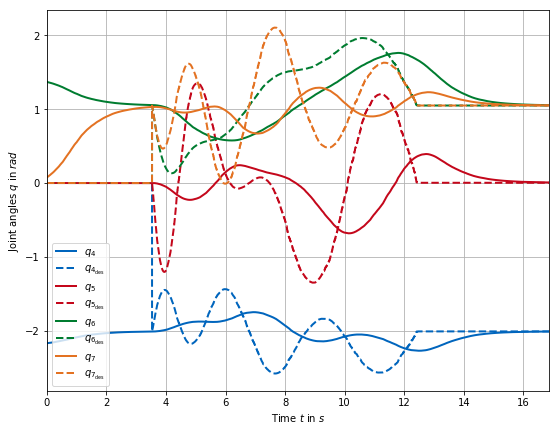

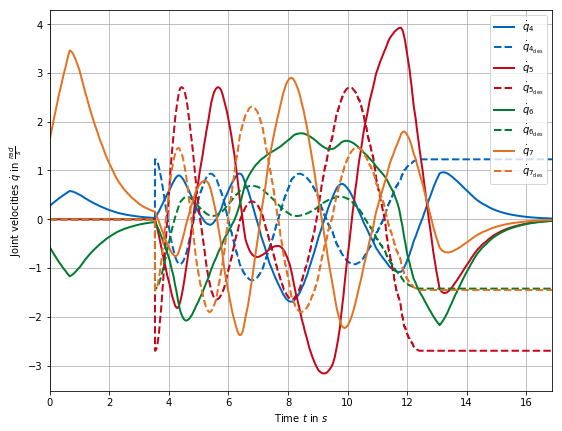

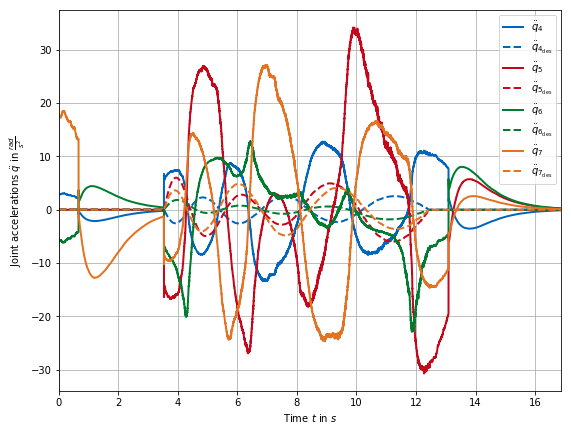

In [112]:
joint_angles_compare(time, axis, trajectory_sim.q_axis, trajectory_sim.q_des, 0)
joint_angles_compare(time, axis, trajectory_sim.dq_axis, trajectory_sim.dq_des, 1)
joint_angles_compare(time, axis, trajectory_sim.ddq_axis, trajectory_sim.ddq_des, 2)

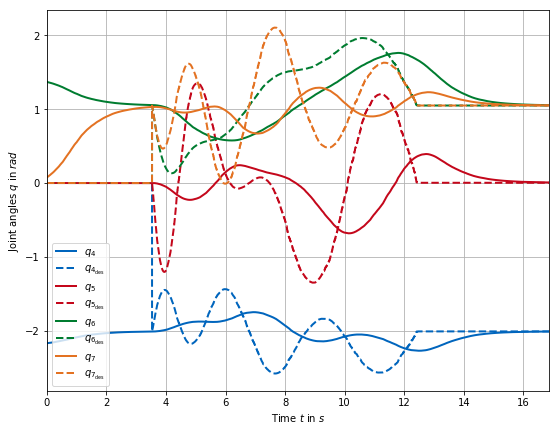

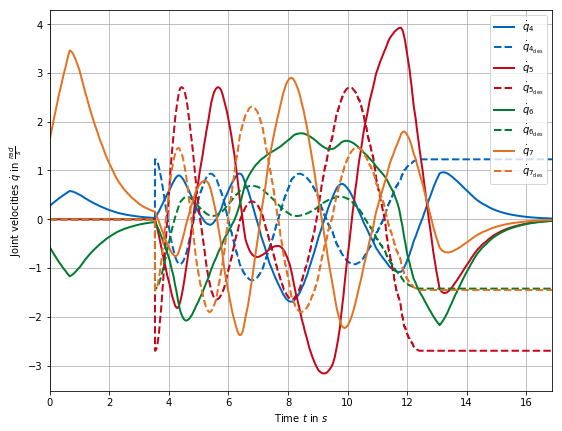

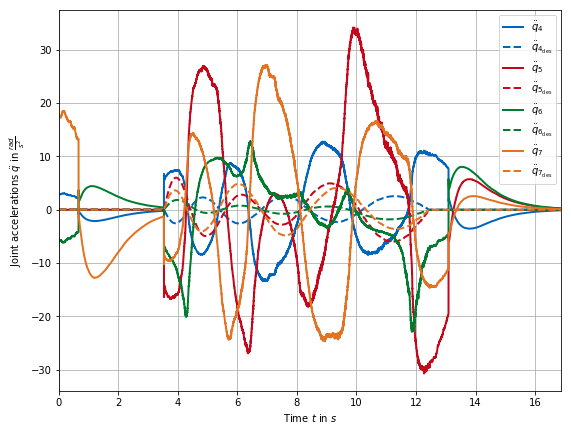

In [113]:
joint_angles_compare(time, axis, trajectory_sim.q_axis, trajectory_sim.q_des, 0)
joint_angles_compare(time, axis, trajectory_sim.dq_axis, trajectory_sim.dq_des, 1)
joint_angles_compare(time, axis, trajectory_sim.ddq_axis, trajectory_sim.ddq_des, 2)

#### Compare trajectory computed during runtime, precomputed in Python

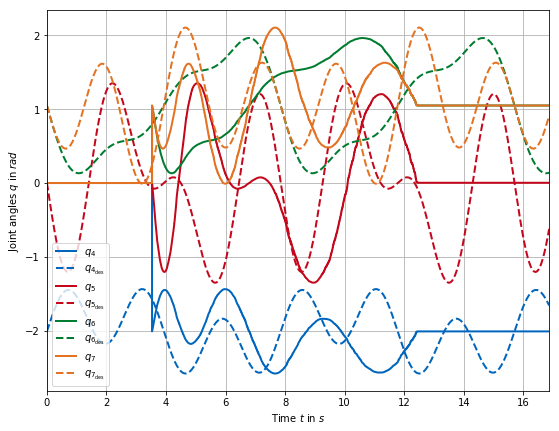

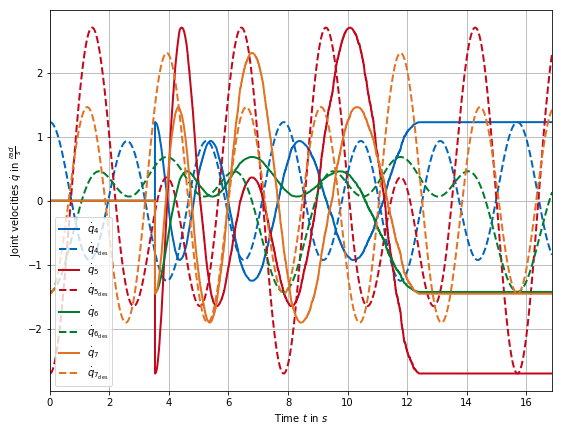

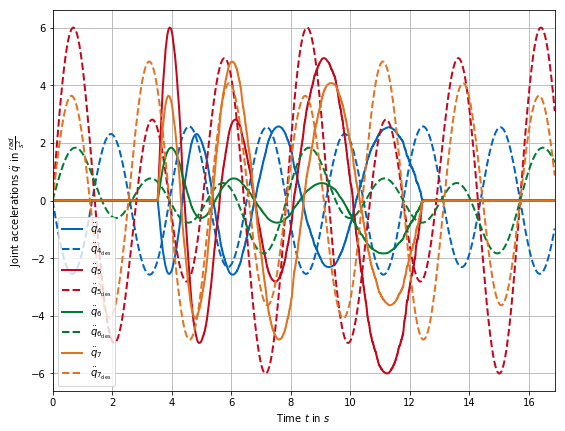

In [114]:
joint_angles_compare(time, axis, q_des, q_fourier, 0)
joint_angles_compare(time, axis, dq_des, dq_fourier, 1)
joint_angles_compare(time, axis, ddq_des, ddq_fourier, 2)


### Force and Torque

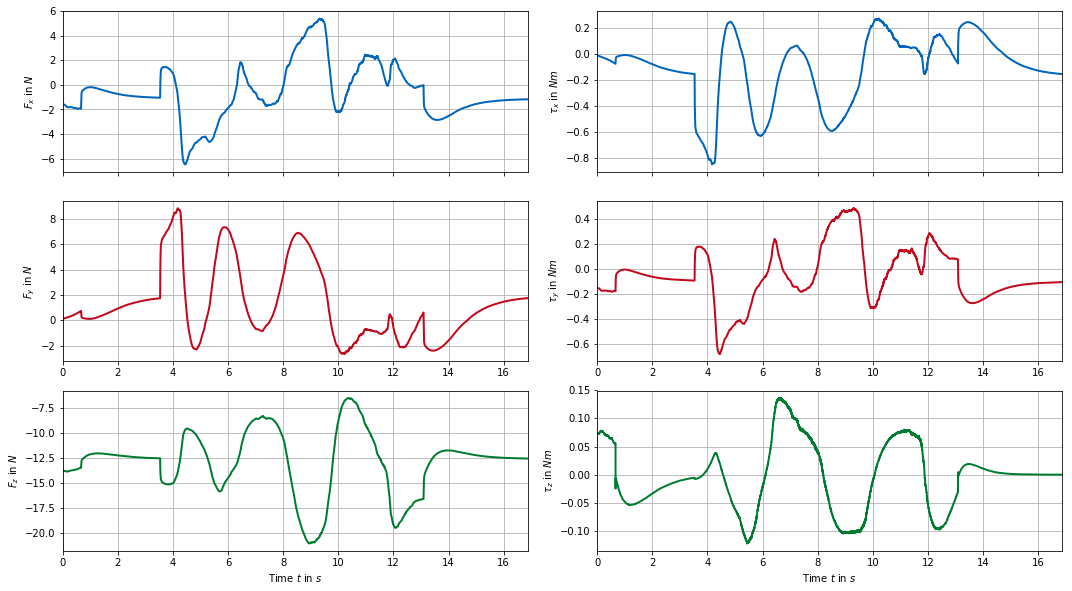

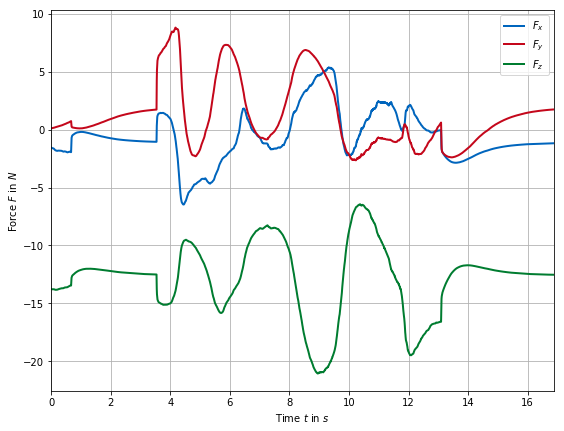

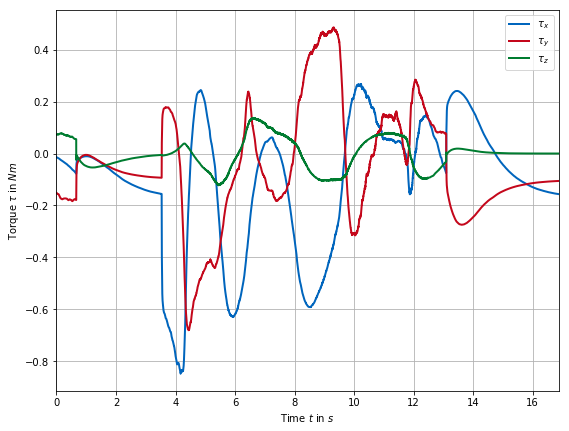

In [115]:
force_torque(time, force_virtual, torque_virtual)
xyz(time, force_virtual, "Force", r"$F$", r"$N$")
xyz(time, torque_virtual, "Torque", r"$\tau$", r"$Nm$")

### Inertial parameters

In [116]:
phi_RLS

array([[ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       ...,
       [ 1.30002e+00, -9.16081e-05, -5.75279e-05, ...,  1.47756e-02,
         3.26941e-07,  4.22973e-03],
       [ 1.30002e+00, -9.16081e-05, -5.75279e-05, ...,  1.47756e-02,
         3.26941e-07,  4.22973e-03],
       [ 1.30002e+00, -9.16081e-05, -5.75279e-05, ...,  1.47756e-02,
         3.26941e-07,  4.22973e-03]])

IndexError: index 0 is out of bounds for axis 0 with size 0

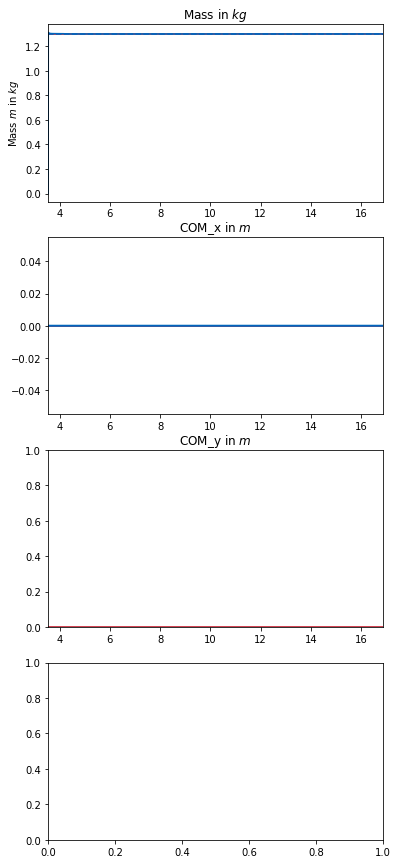

In [117]:
Plot_intertial_params_one(time, phi_RLS, params)

### Kinematics and gravity

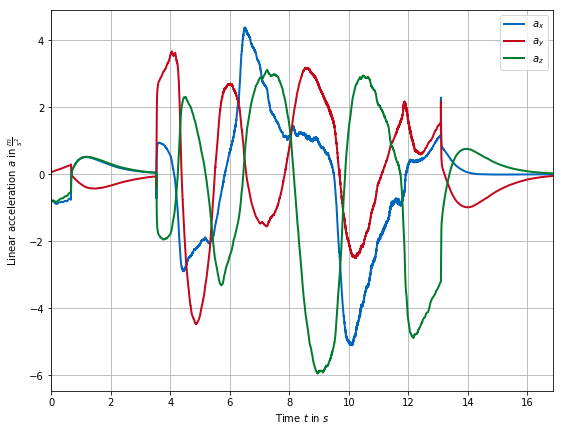

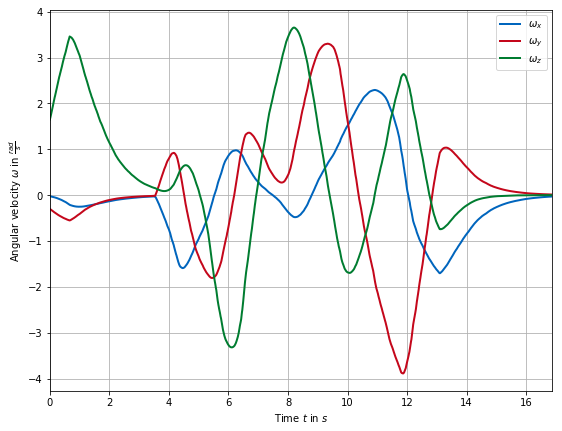

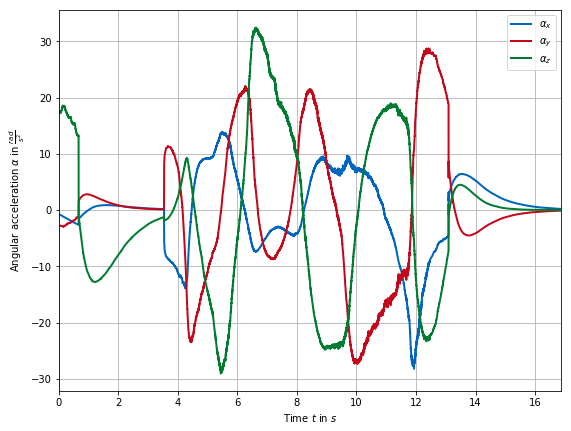

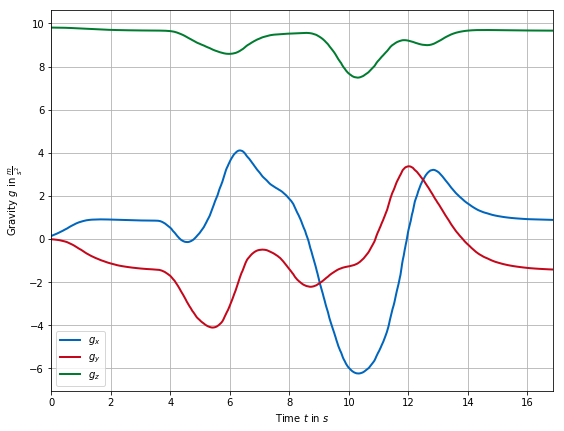

In [118]:
xyz(time, sinusoidal_sim_estimation.accel, "Linear acceleration", "$a$", r"$\frac{m}{s^2}$")
xyz(time, sinusoidal_sim_estimation.avel, "Angular velocity", r"$\omega$", r"$\frac{rad}{s}$")
xyz(time, sinusoidal_sim_estimation.aaccel, "Angular acceleration", r"$\alpha$", r"$\frac{rad}{s^2}$")
xyz(time, sinusoidal_sim_estimation.gravity, "Gravity" , "$g$", r"$\frac{m}{s^2}$" )

## Hardware
### Joint Trajectory
#### Compare desired trajectory, actual trajectory

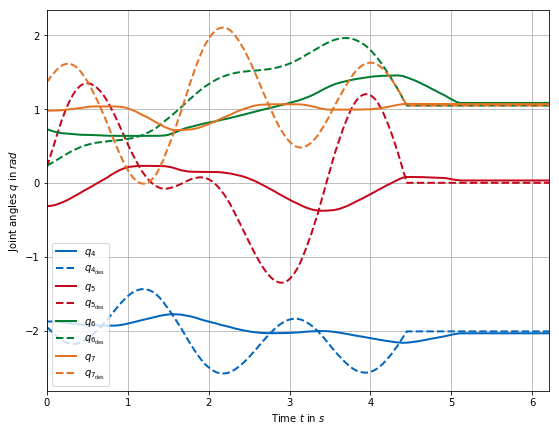

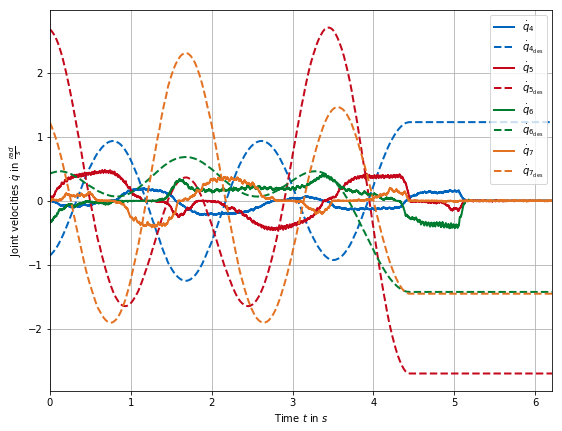

In [119]:
joint_angles_compare(time_hw, axis, trajectory_hw.q_axis, trajectory_hw.q_des, 0)
joint_angles_compare(time_hw, axis, trajectory_hw.dq_axis, trajectory_hw.dq_des, 1)

#### Compare trajectory computed during runtime, precomputed in Python

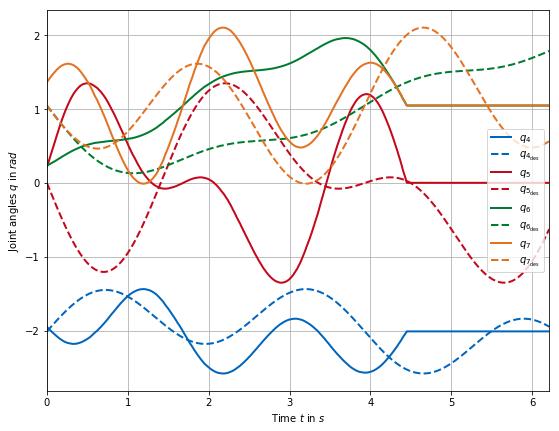

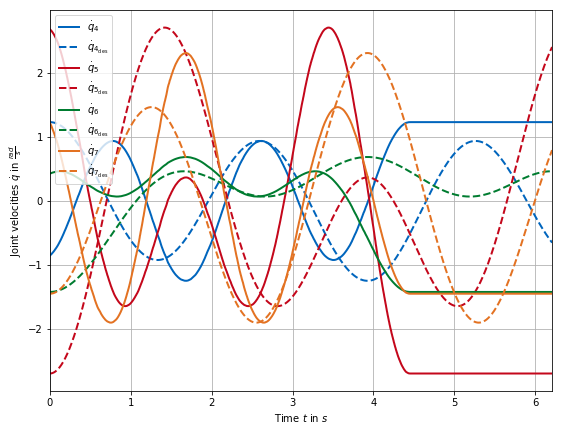

In [120]:
joint_angles_compare(time_hw, axis, trajectory_hw.q_des, q_fourier_hw, 0)
joint_angles_compare(time_hw, axis, trajectory_hw.dq_des, dq_fourier_hw, 1)

### Force and Torque

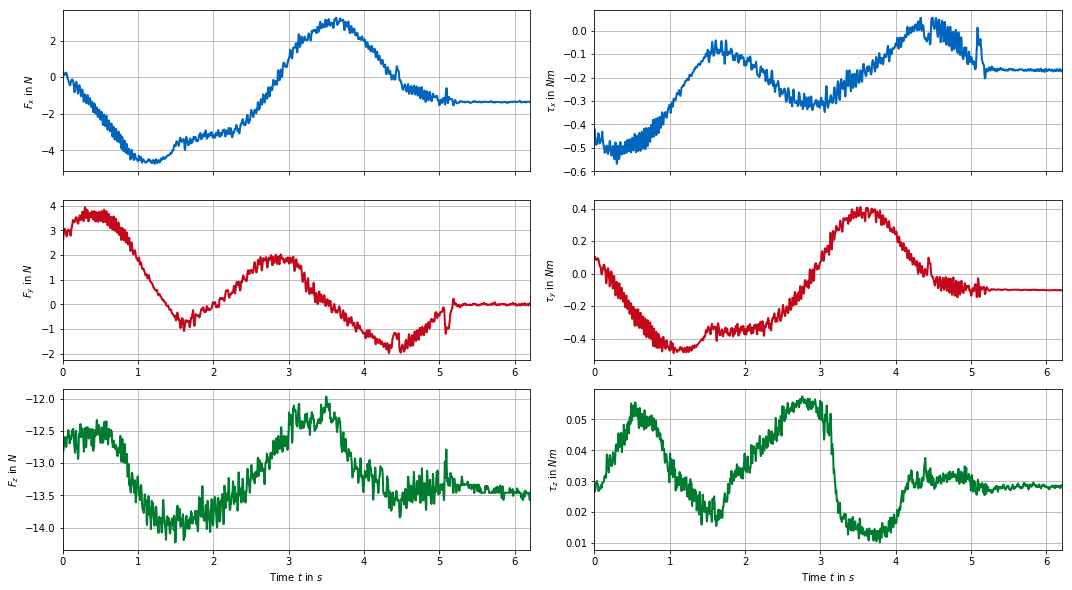

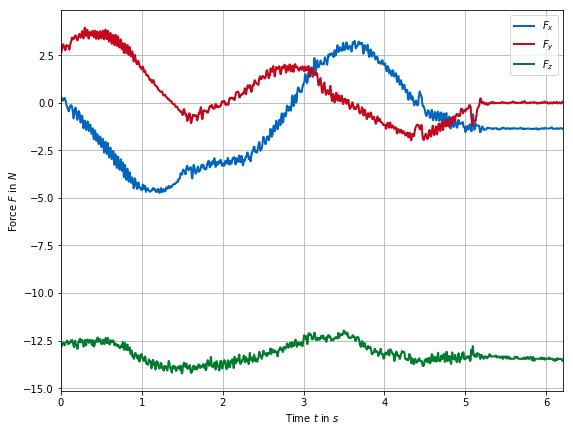

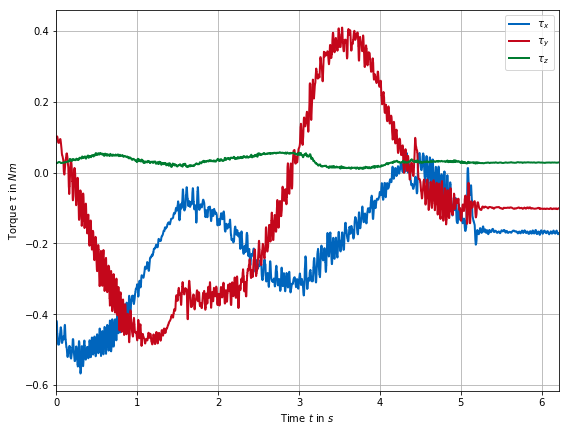

In [121]:
force_torque(time_hw,  sinusoidal_hw_estimation.force, sinusoidal_hw_estimation.torque)
xyz(time_hw, sinusoidal_hw_estimation.force, "Force", r"$F$", r"$N$")
xyz(time_hw, sinusoidal_hw_estimation.torque, "Torque", r"$\tau$", r"$Nm$")

### Kinematics and gravity

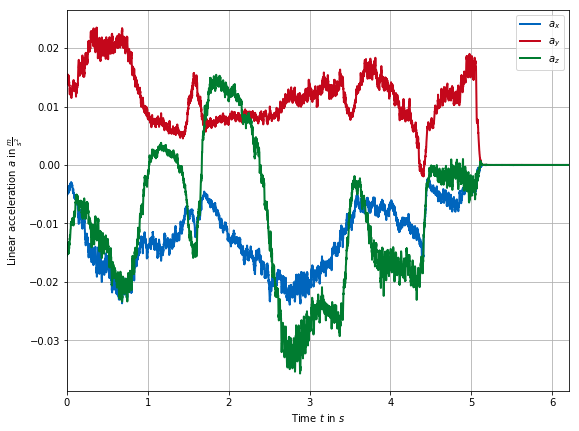

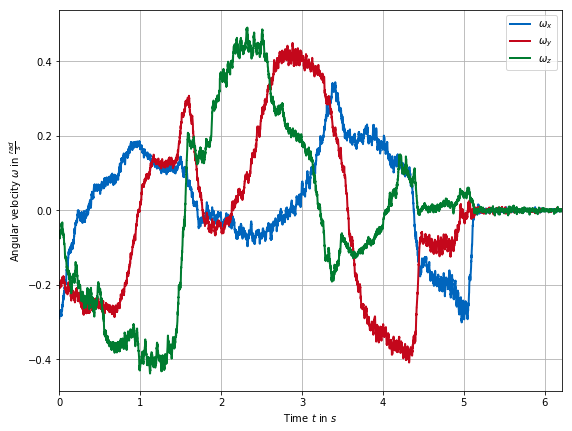

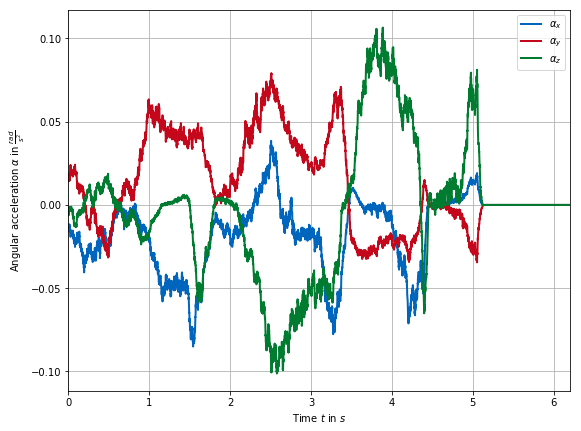

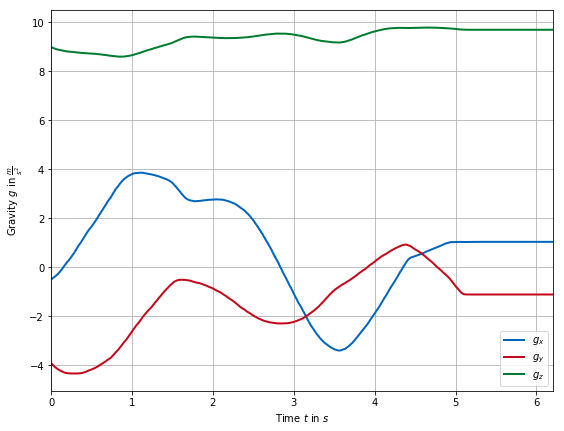

In [122]:
xyz(time_hw, sinusoidal_hw_estimation.accel, "Linear acceleration", "$a$", r"$\frac{m}{s^2}$")
xyz(time_hw, sinusoidal_hw_estimation.avel, "Angular velocity", r"$\omega$", r"$\frac{rad}{s}$")
xyz(time_hw, sinusoidal_hw_estimation.aaccel, "Angular acceleration", r"$\alpha$", r"$\frac{rad}{s^2}$")
xyz(time_hw, sinusoidal_hw_estimation.gravity, "Gravity" , "$g$", r"$\frac{m}{s^2}$" )

## Comparing Simulation and Hardware

### Gravity

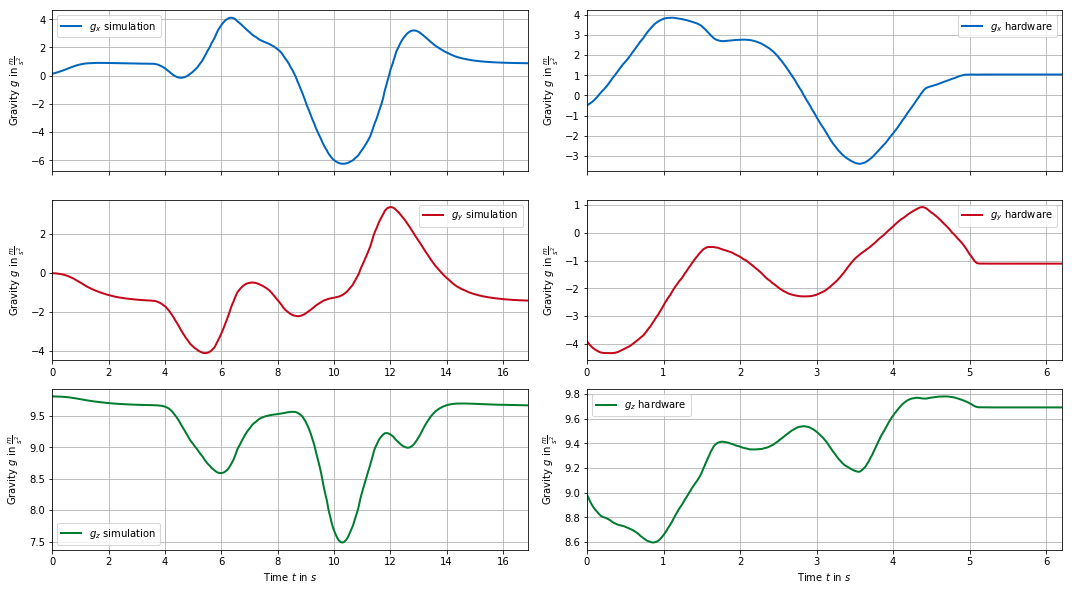

In [123]:
sim_hard(time,sinusoidal_sim_estimation.gravity, time_hw, sinusoidal_hw_estimation.gravity, "Gravity" , "$g$", r"$\frac{m}{s^2}$", "simulation", "hardware" ,3)


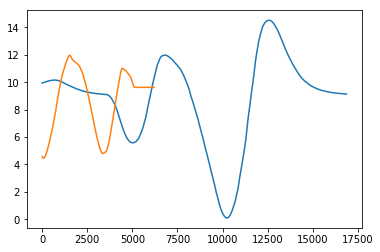

In [124]:
g_aux = np.zeros(time.size)
g_hw_aux = np.zeros(time_hw.size)
for i in np.arange(time.size):
    g_aux[i] = gravity[i,0]  + gravity[i,1] + gravity[i,2]
for i in np.arange(time_hw.size):
    g_hw_aux[i] = (gravity_hw[i,0]  + gravity_hw[i,1] + gravity_hw[i,2])
    
plt.plot(g_aux)
plt.plot(g_hw_aux)


### Linear Acceleration

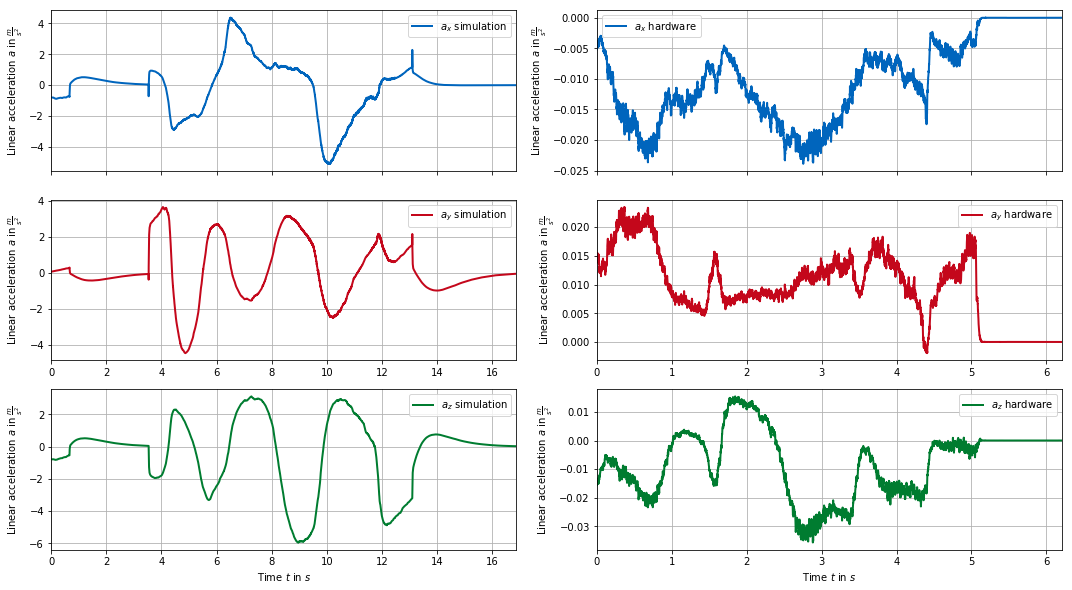

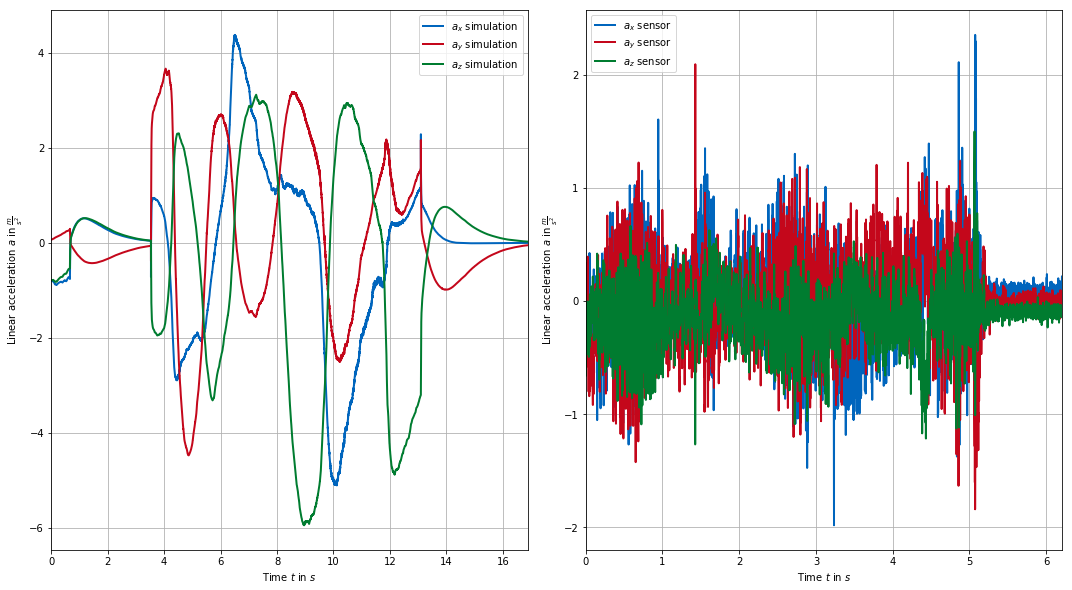

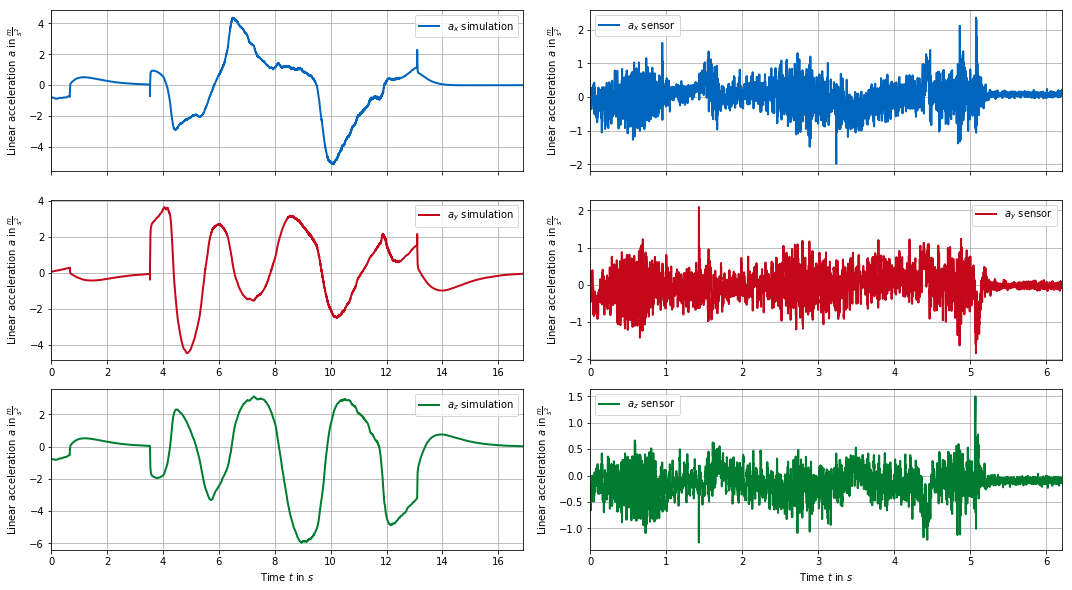

In [125]:
sim_hard(time,sinusoidal_sim_estimation.accel, time_hw,sinusoidal_hw_estimation.accel,  "Linear acceleration", "$a$", r"$\frac{m}{s^2}$","simulation", "hardware" ,3)
sim_hard(time,sinusoidal_sim_estimation.accel, time_hw, accel_sensor*9.81+gravity_hw, "Linear acceleration", "$a$", r"$\frac{m}{s^2}$","simulation", "sensor" ,1)
sim_hard(time,sinusoidal_sim_estimation.accel, time_hw,accel_sensor*9.81+gravity_hw, "Linear acceleration", "$a$", r"$\frac{m}{s^2}$","simulation", "sensor" ,3)


### Angular Velocity

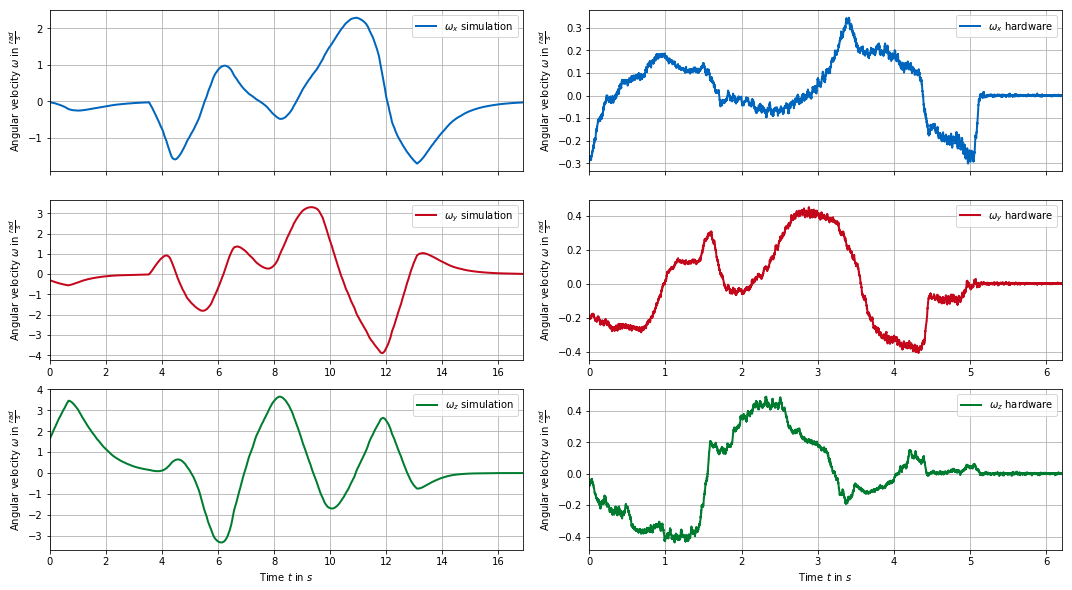

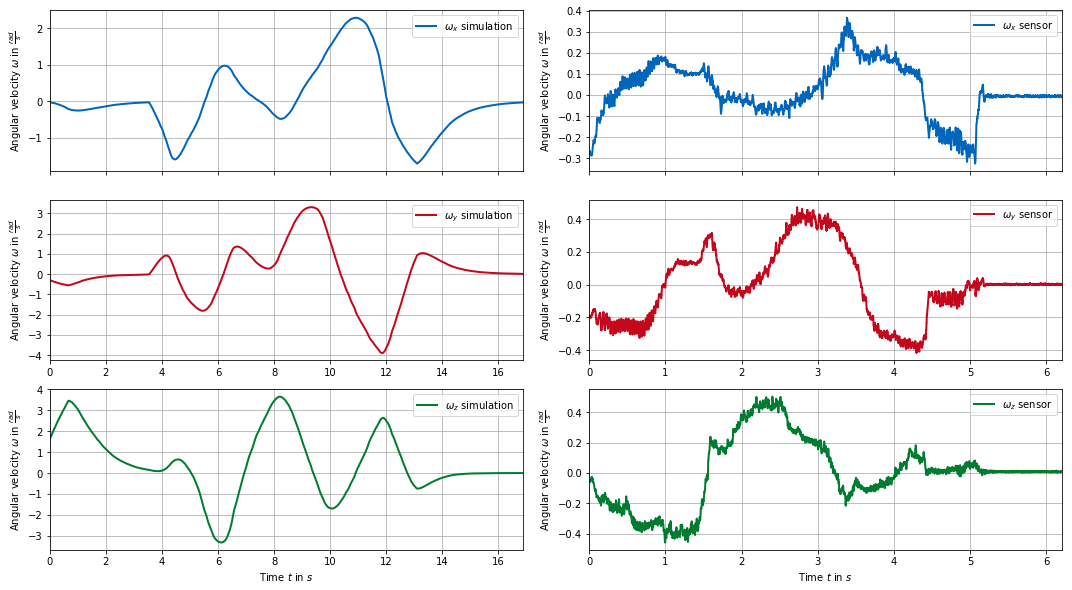

In [126]:
sim_hard(time,sinusoidal_sim_estimation.avel, time_hw, sinusoidal_hw_estimation.avel,   "Angular velocity", r"$\omega$", r"$\frac{rad}{s}$","simulation", "hardware" ,3)
sim_hard(time,sinusoidal_sim_estimation.avel,time_hw, avel_sensor,   "Angular velocity", r"$\omega$", r"$\frac{rad}{s}$","simulation", "sensor" ,3)


### Angular Acceleration

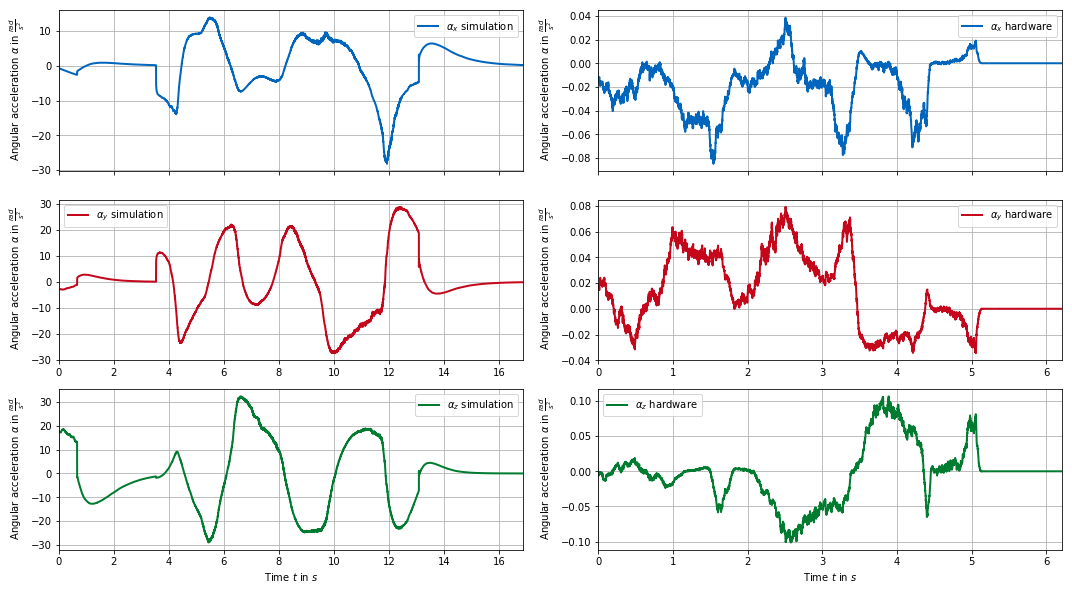

In [127]:
sim_hard(time,aaccel, time_hw, sinusoidal_hw_estimation.aaccel," Angular acceleration", r"$\alpha$", r"$\frac{rad}{s^2}$","simulation", "hardware" ,3)


### Force and Torque

In [ ]:
sim_hard(time,sinusoidal_sim_estimation.force, time_hw, sinusoidal_hw_estimation.force,  "Force", r"$F$", r"$N$","simulation", "hardware" ,3)
sim_hard(time,sinusoidal_sim_estimation.torque, time_hw, sinusoidal_hw_estimation.torque, "Torque", r"$\tau$", r"$Nm$","simulation", "sensor" ,3)


In [ ]:
sim_hard(time,gravity*1.3, time_hw, gravity_hw*1.3,  "Force", r"$F$", r"$N$","simulation", "hardware" ,3)

### Joint Trajectory

In [ ]:
joint_angles_sim_hard(axis, time, trajectory_sim.q_axis, time_hw, trajectory_hw.q_axis, 0)
joint_angles_sim_hard(axis, time, trajectory_sim.dq_axis, time_hw, trajectory_hw.dq_axis, 1)

## Inputs examination

### Data loading and value assignment - simulation

In [ ]:
data_file_kin = "data_file_04-14-19_14-25-41"  

logger_frequency_kin = 1000
# path_simulation = "/Users/elenakern/university/masters/sai-2/apps/inertial_parameter_application/data_collection/simulation/inertial_params_est/"
path_kin = "/home/elenakern/Codes/sai2.0/applications/inertial_params_application/data_collection/simulation/local_global_kinematics_simulation/"
path_data_file_kin = path_kin + data_file_kin

file_kin = np.loadtxt(path_data_file_kin,skiprows=1)

pos_local_kin    = file_kin[0::,0:3]    
vel_local_kin    = file_kin[0::,3:6]     
accel_local_kin  = file_kin[0::,6:9]     
avel_local_kin   = file_kin[0::,9:12]   
aaccel_local_kin = file_kin[0::,12:15]   
g_local_kin      = file_kin[0::,15:18]  
pos_global_kin   = file_kin[0::,18:21]     
vel_global_kin   = file_kin[0::,21:24]     
accel_global_kin = file_kin[0::,24:27]   
avel_global_kin  = file_kin[0::,27:30]
aaccel_global_kin= file_kin[0::,30:33]


time_kin = np.arange(np.size(file_kin[:,0]))
time_kin = time_kin/logger_frequency_kin

In [ ]:
sim_local = KinematicsData(pos_local_kin, vel_local_kin, accel_local_kin, avel_local_kin, aaccel_local_kin)
sim_local.addGravity(g_local_hw_kin)
sim_global = KinematicsData(pos_global_kin, vel_global_kin, accel_global_kin, avel_global_kin, aaccel_global_kin)


### Data loading and value assignment - hardware

In [ ]:
data_file_hw_kin = "data_file_04-14-19_15-58-52"
  

logger_frequency_hw_kin = 1000
# path_simulation = "/Users/elenakern/university/masters/sai-2/apps/inertial_parameter_application/data_collection/simulation/inertial_params_est/"
path_hw_kin = "/home/elenakern/Codes/sai2.0/applications/inertial_params_application/data_collection/hardware/local_global_kinematics_hardware/"
path_data_file_hw_kin = path_hw_kin + data_file_hw_kin

file_hw_kin = np.loadtxt(path_data_file_hw_kin,skiprows=1)

pos_local_hw_kin    = file_hw_kin[0::,0:3]    
vel_local_hw_kin    = file_hw_kin[0::,3:6]     
accel_local_hw_kin  = file_hw_kin[0::,6:9]     
avel_local_hw_kin   = file_hw_kin[0::,9:12]   
aaccel_local_hw_kin = file_hw_kin[0::,12:15]   
g_local_hw_kin      = file_hw_kin[0::,15:18]  
pos_global_hw_kin   = file_hw_kin[0::,18:21]     
vel_global_hw_kin   = file_hw_kin[0::,21:24]     
accel_global_hw_kin = file_hw_kin[0::,24:27]   
avel_global_hw_kin  = file_hw_kin[0::,27:30]
aaccel_global_hw_kin= file_hw_kin[0::,30:33]

accel_global_hw_sensor_aux = file_hw_kin[0::,33:36]   
avel_global_hw_sensor_aux  = file_hw_kin[0::,36:39]

accel_global_hw_sensor = rotate_in_force_sensor_frame(accel_global_hw_sensor_aux)
avel_global_hw_sensor = rotate_in_force_sensor_frame(avel_global_hw_sensor_aux)

accel_global_hw_sensor = accel_global_hw_sensor*9.81 + g_local_hw_kin
# avel_global_hw_sensor = avel_global_hw_sensor*np.pi/180.0

time_hw_kin = np.arange(np.size(file_hw_kin[:,0]))
time_hw_kin = time_hw_kin/logger_frequency_hw_kin

In [ ]:
hw_local = KinematicsData(pos_local_hw_kin, vel_local_hw_kin, accel_local_hw_kin, avel_local_hw_kin, aaccel_local_hw_kin)
hw_local.addGravity(g_local_hw_kin)
hw_global = KinematicsData(pos_global_hw_kin, vel_global_hw_kin, accel_global_hw_kin, avel_global_hw_kin, aaccel_global_hw_kin)
IMUsensor = IMUSensor(accel_global_hw_sensor, avel_global_hw_sensor)

### Get derivatives of measurements

In [ ]:
file_kin_dot = get_derivative(file_kin, logger_frequency_kin)

pos_local_kin_dot    = file_kin_dot[0::,0:3]    
vel_local_kin_dot    = file_kin_dot[0::,3:6]     
accel_local_kin_dot  = file_kin_dot[0::,6:9]     
avel_local_kin_dot   = file_kin_dot[0::,9:12]   
aaccel_local_kin_dot = file_kin_dot[0::,12:15]   
g_local_kin_dot      = file_kin_dot[0::,15:18]  
pos_global_kin_dot   = file_kin_dot[0::,18:21]     
vel_global_kin_dot   = file_kin_dot[0::,21:24]     
accel_global_kin_dot = file_kin_dot[0::,24:27]   
avel_global_kin_dot  = file_kin_dot[0::,27:30]
aaccel_global_kin_dot= file_kin_dot[0::,30:33]

In [ ]:
sim_local.computeDerivatives(logger_frequency_kin)
sim_global.computeDerivatives(logger_frequency_kin)

In [ ]:
file_hw_kin_dot = get_derivative(file_hw_kin, logger_frequency_hw_kin)

pos_local_hw_kin_dot    = file_hw_kin_dot[0::,0:3]    
vel_local_hw_kin_dot    = file_hw_kin_dot[0::,3:6]     
accel_local_hw_kin_dot  = file_hw_kin_dot[0::,6:9]     
avel_local_hw_kin_dot   = file_hw_kin_dot[0::,9:12]   
aaccel_local_hw_kin_dot = file_hw_kin_dot[0::,12:15]   
g_local_hw_kin_dot      = file_hw_kin_dot[0::,15:18]  
pos_global_hw_kin_dot   = file_hw_kin_dot[0::,18:21]     
vel_global_hw_kin_dot   = file_hw_kin_dot[0::,21:24]     
accel_global_hw_kin_dot = file_hw_kin_dot[0::,24:27]   
avel_global_hw_kin_dot  = file_hw_kin_dot[0::,27:30]
aaccel_global_hw_kin_dot= file_hw_kin_dot[0::,30:33]

In [ ]:
hw_local.computeDerivatives(logger_frequency_hw_kin)
hw_global.computeDerivatives(logger_frequency_hw_kin)

In [ ]:
Fs = logger_frequency_hw_kin
Ts = 1.0 / Fs
t = time_hw_kin
n = len(vel_global_hw_kin[:,0])
k = np.arange(n)
T = n/Fs
frq_two_sides = k/T
frq_one_side = frq_two_sides[range(int(n/2.0))]
Y = np.fft.fft(vel_global_hw_kin[:,0])/n
Y = Y[range(int(n/2.0))]




In [ ]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(t,vel_global_hw_kin[:,0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq_one_side,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')

In [ ]:
print(time_kin.shape)
print(pos_global_kin.shape)
print(vel_global_kin.shape)
print(pos_global_kin.shape)
print(pos_global_kin_dot.shape)

### Plots derivatives

In [ ]:
label_list = ["measured", "computed"]

#### Global

In [ ]:
sim_global.computeFilteredDerivatives(logger_frequency_kin,0.8,5)

In [ ]:
xyz_subplots_three_inputs_two_axes(time_kin,sim_global.pos, sim_global.vel, sim_global.pos_dot, pos_info,vel_info,label_list)
xyz_subplots_three_inputs_two_axes(time_kin,sim_global.pos, sim_global.vel, sim_global.pos_dot_filt, pos_info,vel_info,label_list)


In [ ]:
xyz_subplots_three_inputs_two_axes(time_hw_kin, hw_global.pos, hw_global.vel, hw_global.pos_dot, pos_info,vel_info,label_list)


In [ ]:
xyz_subplots_three_inputs_two_axes(time_kin,sim_global.vel, sim_global.accel, sim_global.vel_dot, vel_info,accel_info,label_list)


In [ ]:
xyz_subplots_three_inputs_two_axes(time_hw_kin,vel_global_hw_kin, accel_global_hw_kin, vel_global_hw_kin_dot, vel_info,accel_info,label_list)


In [ ]:
xyz_subplots_three_inputs_two_axes(time_kin, avel_global_kin, aaccel_global_kin, avel_global_kin_dot, avel_info,aaccel_info,label_list)


In [ ]:
xyz_subplots_three_inputs_two_axes(time_hw_kin, avel_global_hw_kin, aaccel_global_hw_kin, avel_global_hw_kin_dot, avel_info, aaccel_info,label_list)


#### Local

In [ ]:
xyz_subplots_three_inputs_two_axes(time_kin,pos_local_kin, vel_local_kin, pos_local_kin_dot, pos_info,vel_info,label_list)


In [ ]:
xyz_subplots_three_inputs_two_axes(time_hw_kin,pos_local_hw_kin, vel_local_hw_kin, pos_local_hw_kin_dot, pos_info,vel_info,label_list)


In [ ]:
xyz_subplots_three_inputs_two_axes(time_kin,vel_local_kin, accel_local_kin, vel_local_kin_dot, vel_info, accel_info,label_list)


In [ ]:
xyz_subplots_three_inputs_two_axes(time_hw_kin,vel_local_hw_kin, accel_local_hw_kin, vel_local_hw_kin_dot, vel_info, accel_info,label_list)


In [ ]:
xyz_subplots_three_inputs_two_axes(time_kin,avel_local_kin,aaccel_local_kin, avel_local_kin_dot, avel_info, aaccel_info,label_list)


In [ ]:
xyz_subplots_three_inputs_two_axes(time_hw_kin,avel_local_hw_kin,aaccel_local_hw_kin, avel_local_hw_kin_dot, avel_info, aaccel_info,label_list)


#### Fouriertransform

In [ ]:
avel_local_hw_kin_filtered = np.zeros(avel_local_hw_kin.shape)
for i in np.arange(3):
    xn = avel_local_hw_kin[:,i]
    t = time_hw_kin
    b, a = butter(5, 0.008)
    y = filtfilt(b, a, xn)
    avel_local_hw_kin_filtered[:,i] = y
labels_filt = ["measured","filtered"]    
xyz_subplots_two_inputs(time_hw_kin, avel_local_hw_kin, avel_local_hw_kin_filtered, avel_info,labels_filt)

In [ ]:
avel_local_hw_kin_filtered_dot = get_derivative(avel_local_hw_kin_filtered, logger_frequency_hw_kin)

xyz_subplots_three_inputs_two_axes(time_hw_kin,avel_local_hw_kin_filtered,aaccel_local_hw_kin,avel_local_hw_kin_filtered_dot, avel_info, aaccel_info,label_list)


In [ ]:
for i in np.arange(3):
    plot_fourier_transform(time_hw_kin, avel_local_hw_kin[:,i], logger_frequency_hw_kin, -4, 5)


In [ ]:
vel_local_hw_kin_filtered = filter_butter(vel_local_hw_kin,0.8,logger_frequency_hw_kin,6)
vel_local_hw_kin_filtered_dot = get_derivative(vel_local_hw_kin_filtered, logger_frequency_hw_kin)

xyz_subplots_three_inputs_two_axes(time_hw_kin,vel_local_hw_kin_filtered,accel_local_hw_kin,vel_local_hw_kin_filtered_dot, vel_info, accel_info,label_list)


In [ ]:
accel_global_hw_sensor_filtered = filter_butter(accel_global_hw_sensor,0.8, logger_frequency_hw_kin,1) 
xyz_obj(time_hw_kin, accel_global_hw_sensor_filtered, accel_info)
xyz_obj(time_hw_kin, accel_global_hw_sensor, accel_info)

In [ ]:
labels_1 = ["derivative of filtered velocity", "accelerometer filtered"]
xyz_subplots_two_inputs_two_axes(time_hw_kin, vel_local_hw_kin_filtered_dot,accel_global_hw_sensor_filtered, accel_info,accel_info,labels_1)

In [ ]:
labels_2 = ["derived from joint measurements, filtered", "IMU filtered"]
avel_global_hw_sensor_filtered = filter_butter(avel_global_hw_sensor,10,logger_frequency_hw_kin,5) 
avel_local_hw_kin_filtered = filter_butter(avel_local_hw_kin,10,logger_frequency_hw_kin,5) 
xyz_subplots_two_inputs(time_hw_kin, avel_local_hw_kin_filtered,avel_global_hw_sensor_filtered,avel_info,labels_2)

In [ ]:
logger_frequency_hw_kin

In [ ]:
avel_global_hw_sensor_filtered = filter_butter(avel_global_hw_sensor,0.8, logger_frequency_hw_kin,5) 

xyz_obj(time_hw_kin, avel_global_hw_sensor_filtered, avel_info)
xyz_obj(time_hw_kin, avel_global_hw_sensor, avel_info)

## Filtered inputs

In [ ]:
data_file_filtered = "data_file_04-14-19_23-50-41"
  

logger_frequency_filtered = 1000
# path_simulation = "/Users/elenakern/university/masters/sai-2/apps/inertial_parameter_application/data_collection/simulation/inertial_params_est/"
path_filtered = "/home/elenakern/Codes/sai2.0/applications/inertial_params_application/data_collection/hardware/filtered_hardware/"
path_data_file_filtered = path_filtered + data_file_filtered

file_filtered = np.loadtxt(path_data_file_filtered,skiprows=1)

pos_aux    = file_filtered[0::,0:3]    
vel_aux    = file_filtered[0::,3:6]  

accel_butter_filtered  = file_filtered[0::,6:9]     
avel_butter_filtered   = file_filtered[0::,9:12]   

aaccel_filtered        = file_filtered[0::,12:15]   
g_local_filtered      = file_filtered[0::,15:18]  

accel_lp_filtered  = file_filtered[0::,18:21]     
avel_lp_filtered   = file_filtered[0::,21:24]   
aaccel_lp_filtered = file_filtered[0::,24:27]

accel_sensor_aux = file_filtered[0::,27:30]   
avel_sensor_aux  = file_filtered[0::,30:303]

accel_sensor = rotate_in_force_sensor_frame(accel_sensor_aux)
avel_sensor = rotate_in_force_sensor_frame(avel_sensor_aux)

accel_sensor = accel_sensor*9.81 + g_local_filtered
# avel_global_sensor = avel_global_sensor*np.pi/180.0

time_filtered = np.arange(np.size(file_filtered[:,0]))
time_filtered = time_filtered/logger_frequency_filtered

In [ ]:
data_file_filtered = "data_file_04-15-19_23-31-46"
  

logger_frequency_filtered = 1000
# path_simulation = "/Users/elenakern/university/masters/sai-2/apps/inertial_parameter_application/data_collection/simulation/inertial_params_est/"
path_filtered = "/home/elenakern/Codes/sai2.0/applications/inertial_params_application/data_collection/hardware/filtered_hardware/"
path_data_file_filtered = path_filtered + data_file_filtered

file_filtered = np.loadtxt(path_data_file_filtered,skiprows=1)

pos_aux    = file_filtered[0::,0:3]    
vel_aux    = file_filtered[0::,3:6]  

accel_butter_filtered  = file_filtered[0::,6:9]     
avel_butter_filtered   = file_filtered[0::,9:12]   

aaccel_filtered        = file_filtered[0::,12:15]   
g_local_filtered      = file_filtered[0::,15:18]  

accel_lp_filtered  = file_filtered[0::,18:21]     
avel_lp_filtered   = file_filtered[0::,21:24]   
aaccel_lp_filtered = file_filtered[0::,24:27]

accel_sensor_aux = file_filtered[0::,27:30]   
avel_sensor_aux  = file_filtered[0::,30:303]

accel_sensor = rotate_in_force_sensor_frame(accel_sensor_aux)
avel_sensor = rotate_in_force_sensor_frame(avel_sensor_aux)

accel_sensor = accel_sensor*9.81 + g_local_filtered
# avel_global_sensor = avel_global_sensor*np.pi/180.0

time_filtered = np.arange(np.size(file_filtered[:,0]))
time_filtered = time_filtered/logger_frequency_filtered


In [ ]:
fc = 0.8
order = 5

In [ ]:
avel_sensor_filtered = filter_butter(avel_sensor,fc,logger_frequency_filtered,order)
accel_sensor_filtered = filter_butter(accel_sensor,fc,logger_frequency_filtered,order)
avel_butter_filtered_dot = get_derivative(avel_butter_filtered, logger_frequency_filtered)
avel_sensor_filtered_dot = get_derivative(avel_sensor_filtered, logger_frequency_filtered)

# pos_dot_filtered = ComputeDotFiltered(pos_aux, fc,logger_frequency_filtered,order)
# vel_filtered_dot_filtered = ComputeFilteredDotFiltered(vel_aux, fc,logger_frequency_filtered,order)
avel_butter_filtered_dot_filtered = ComputeDotFiltered(avel_butter_filtered, fc,logger_frequency_filtered,order)


In [ ]:
lowpass_wc_06 = Kinematics(accel_lp_filtered, avel_lp_filtered ,aaccel_lp_filtered )
butter = Kinematics(accel_butter_filtered, avel_butter_filtered, avel_butter_filtered_dot_filtered)
sensor_butter = Kinematics(accel_sensor_filtered, avel_sensor_filtered, avel_sensor_filtered_dot)


In [ ]:
label_butter_lp = ["Butterworth filter", "Low pass filter"]
label_butter_lp_filtfilt = ["Butterworth filter", "Low pass filter", "Butterworth filt-filt"]
label_derivative_sensdot_butterdot_lp = ["derivative of filtered angular velocity, source: Butter","Low-Pass Filter",
                                         "derivative of filtered angular velocity, source: Butter filtfilt" ]
label_derivative_butterdot_lp = ["derivative of filtered angular velocity, source: Butter",
                       "Low-Pass Filter", "derivative of filtered angular velocity, source: sensor"]

label_sensdot_lp = ["derivative of butter filtered angular velocity", "Low-Pass Filter","source: sensor"]
label_lowpass_der = ["Low pass filter", "Low pass filter"]
label_butter_der = ["Butterworth filter", "Butterworth filter derivative filtered with filtfilt"]
label_sensor_der = ["Sensor filtered with filtfilt", "Sensor filtered derivative filtered with filtfilt"]


In [ ]:
xyz_subplots_three_inputs(time_filtered, butter.avel, lowpass.avel, sensor_butter.avel, avel_info,label_butter_lp_filtfilt)


In [ ]:
xyz_subplots_three_inputs(time_filtered, butter.aaccel, lowpass.aaccel, sensor_butter.aaccel, aaccel_info,label_derivative_butterdot_lp)


In [ ]:
xyz_subplots_three_inputs(time_filtered, butter.accel, lowpass.accel, sensor_butter.accel, accel_info,label_butter_lp_filtfilt)


In [ ]:
xyz_subplots_two_inputs_two_axes(time_filtered, lowpass.avel, lowpass.aaccel,avel_info ,aaccel_info ,label_lowpass_der)

In [ ]:
xyz_subplots_two_inputs_two_axes(time_filtered, sensor_butter.avel, sensor_butter.aaccel,avel_info ,aaccel_info ,label_sensor_der)

In [ ]:
label_pos = ["Postition kinematics", "Postition kinematics derivativ filtered"]
xyz_subplots_two_inputs_two_axes(time_filtered, pos_aux, pos_dot_filtered ,pos_info, vel_info, label_pos)

In [ ]:
label = ["Butterworth", "Lowpass", "Sensor filt filt ", "Velocity kinematics filt filt dot filt filt"]
xyz_subplots_four_inputs(time_filtered, butter.accel, lowpass.accel, sensor_butter.accel, vel_filtered_dot_filtered, accel_info, label)
